In [218]:
import numpy as np
import pandas as pd
from functools import reduce
from itertools import combinations

import datetime
import calendar

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import scipy.stats
from patsy import dmatrix,dmatrices
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.graphics.factorplots import interaction_plot

import missingno as msno
from MissForestExtra import MissForestExtra as mfe
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest


In [642]:
colorectal_1 = pd.read_excel('/Users/jnl741/Downloads/Colorectal 10.28.16_final.xlsx')

In [643]:
colorectal_2 = pd.read_excel('/Users/jnl741/Downloads/Colon 10.29.21-6.24.22_final.xlsx')

In [644]:
"""Find common and distinct columns."""

missing_cols_colorectal_1 = []
missing_cols_colorectal_2 = []
common_cols = []
for col in colorectal_1.columns:
    if col in colorectal_2.columns:
        common_cols.append(col)
    else:
        missing_cols_colorectal_2.append(col)
for col in colorectal_2.columns:
    if col not in common_cols:
        missing_cols_colorectal_1.append(col)
 

In [645]:
missing_cols_colorectal_1

['GS (>75) Home Origin Status - Support',
 'Case Acuity',
 'Operative Approach',
 'Robot Used',
 'Hand/Open Assist',
 'Unplanned Conversion to Open',
 'Preop Acute Kidney Injury',
 'Most Severe Preop Creatinine Increase',
 'Lowest Preop Urine Output',
 'Preop Dialysis',
 '# of Postop Renal Insufficiency',
 'Most Severe Postop Creatinine Increase',
 'Lowest Postop Urine Output',
 '# of Postop Dialysis',
 '# of Postop Venous Thrombosis Requiring Therapy']

In [646]:
missing_cols_colorectal_2

['GS (<75) Home Origin Status - Support',
 'Case Status',
 'Acute Renal Failure',
 'Currently requiring or on dialysis',
 '# of Postop Progressive Renal Insufficiency',
 '# of Postop Acute Renal Failure',
 '# of Postop Vein Thrombosis Requiring Therapy',
 'Colectomy Steroid/Immunosuppressant for Inflammatory Bowel',
 'Colectomy Steroid/Immunosuppressant for Inflammatory Bowel Unknown',
 'Colectomy Mechanical Bowel Prep',
 'Colectomy Mechanical Bowel Prep Unknown',
 'Colectomy Oral Antibiotic Prep',
 'Colectomy Oral Antibiotic Prep Unknown',
 'Colectomy Chemotherapy w/in 90 days',
 'Colectomy Chemotherapy w/in 90 days Unknown',
 'Colectomy Primary Indication for Surgery',
 'Colectomy Non-Emergent Indication ICD9 Code',
 'Colectomy Non-Emergent Indication ICD10 Code',
 'Colectomy Indication for Surgery if Emergent',
 'Colectomy Emergent Indication ICD9 Code',
 'Colectomy Emergent Indication ICD10 Code',
 'Colectomy Operative Approach',
 'Colectomy Malignancy, Pathologic T Stage',
 'Colec

In [647]:
"""Looks like these features are common to both datasets, but differentially named: 

'GS (<75) Home Origin Status - Support'
'Colectomy Operative Approach'
'# of Postop Vein Thrombosis Requiring Therapy'
'Case Acuity'

Let's correct those inconsistencies."""

colorectal_1 = colorectal_1.rename(columns = {'GS (<75) Home Origin Status - Support':'GS (>75) Home Origin Status - Support',
                               'Colectomy Operative Approach':'Operative Approach',
                               '# of Postop Vein Thrombosis Requiring Therapy':'# of Postop Venous Thrombosis Requiring Therapy', 
                               'Case Status': 'Case Acuity'})


In [648]:
"""Re-sort common and distinct column names after consolidations of names"""

missing_cols_colorectal_1 = []
missing_cols_colorectal_2 = []
common_cols = []
for col in colorectal_1.columns:
    if col in colorectal_2.columns:
        common_cols.append(col)
    else:
        missing_cols_colorectal_2.append(col)
for col in colorectal_2.columns:
    if col not in common_cols:
        missing_cols_colorectal_1.append(col)

In [649]:
"""Merge the two datasets"""
merged_colorectal = pd.concat([colorectal_1, colorectal_2],axis = 0, ignore_index = True)
merged_colorectal = merged_colorectal[common_cols]

In [650]:
"""Check for duplicated records"""
merged_colorectal.duplicated().sum()

0

In [651]:
"""Define function to clean/standardize column names"""

def clean_column_names (columns):
    cleaned_cols = (columns.str.strip()
                    .str.replace(" ","_")
                    .str.replace("  ","_")
                    .str.replace("-","_")
                    .str.replace(".","_")
                    .str.replace(",","_")
                    .str.replace("/","_")
                    .str.replace('#','Num')
                    .str.lower())
    return cleaned_cols

In [652]:
"""Clean column names'"""
merged_colorectal.columns = clean_column_names(merged_colorectal.columns)


/var/folders/v9/483tmlvj28ldt2s2wvphywvxd4j0g_/T/ipykernel_77189/3324776174.py:4: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [653]:
"""Shorten 'hospital_length_of_stay' to 'length_of_stay'"""

merged_colorectal.rename(columns = {'hospital_length_of_stay':'length_of_stay'}, inplace = True)

<AxesSubplot:>

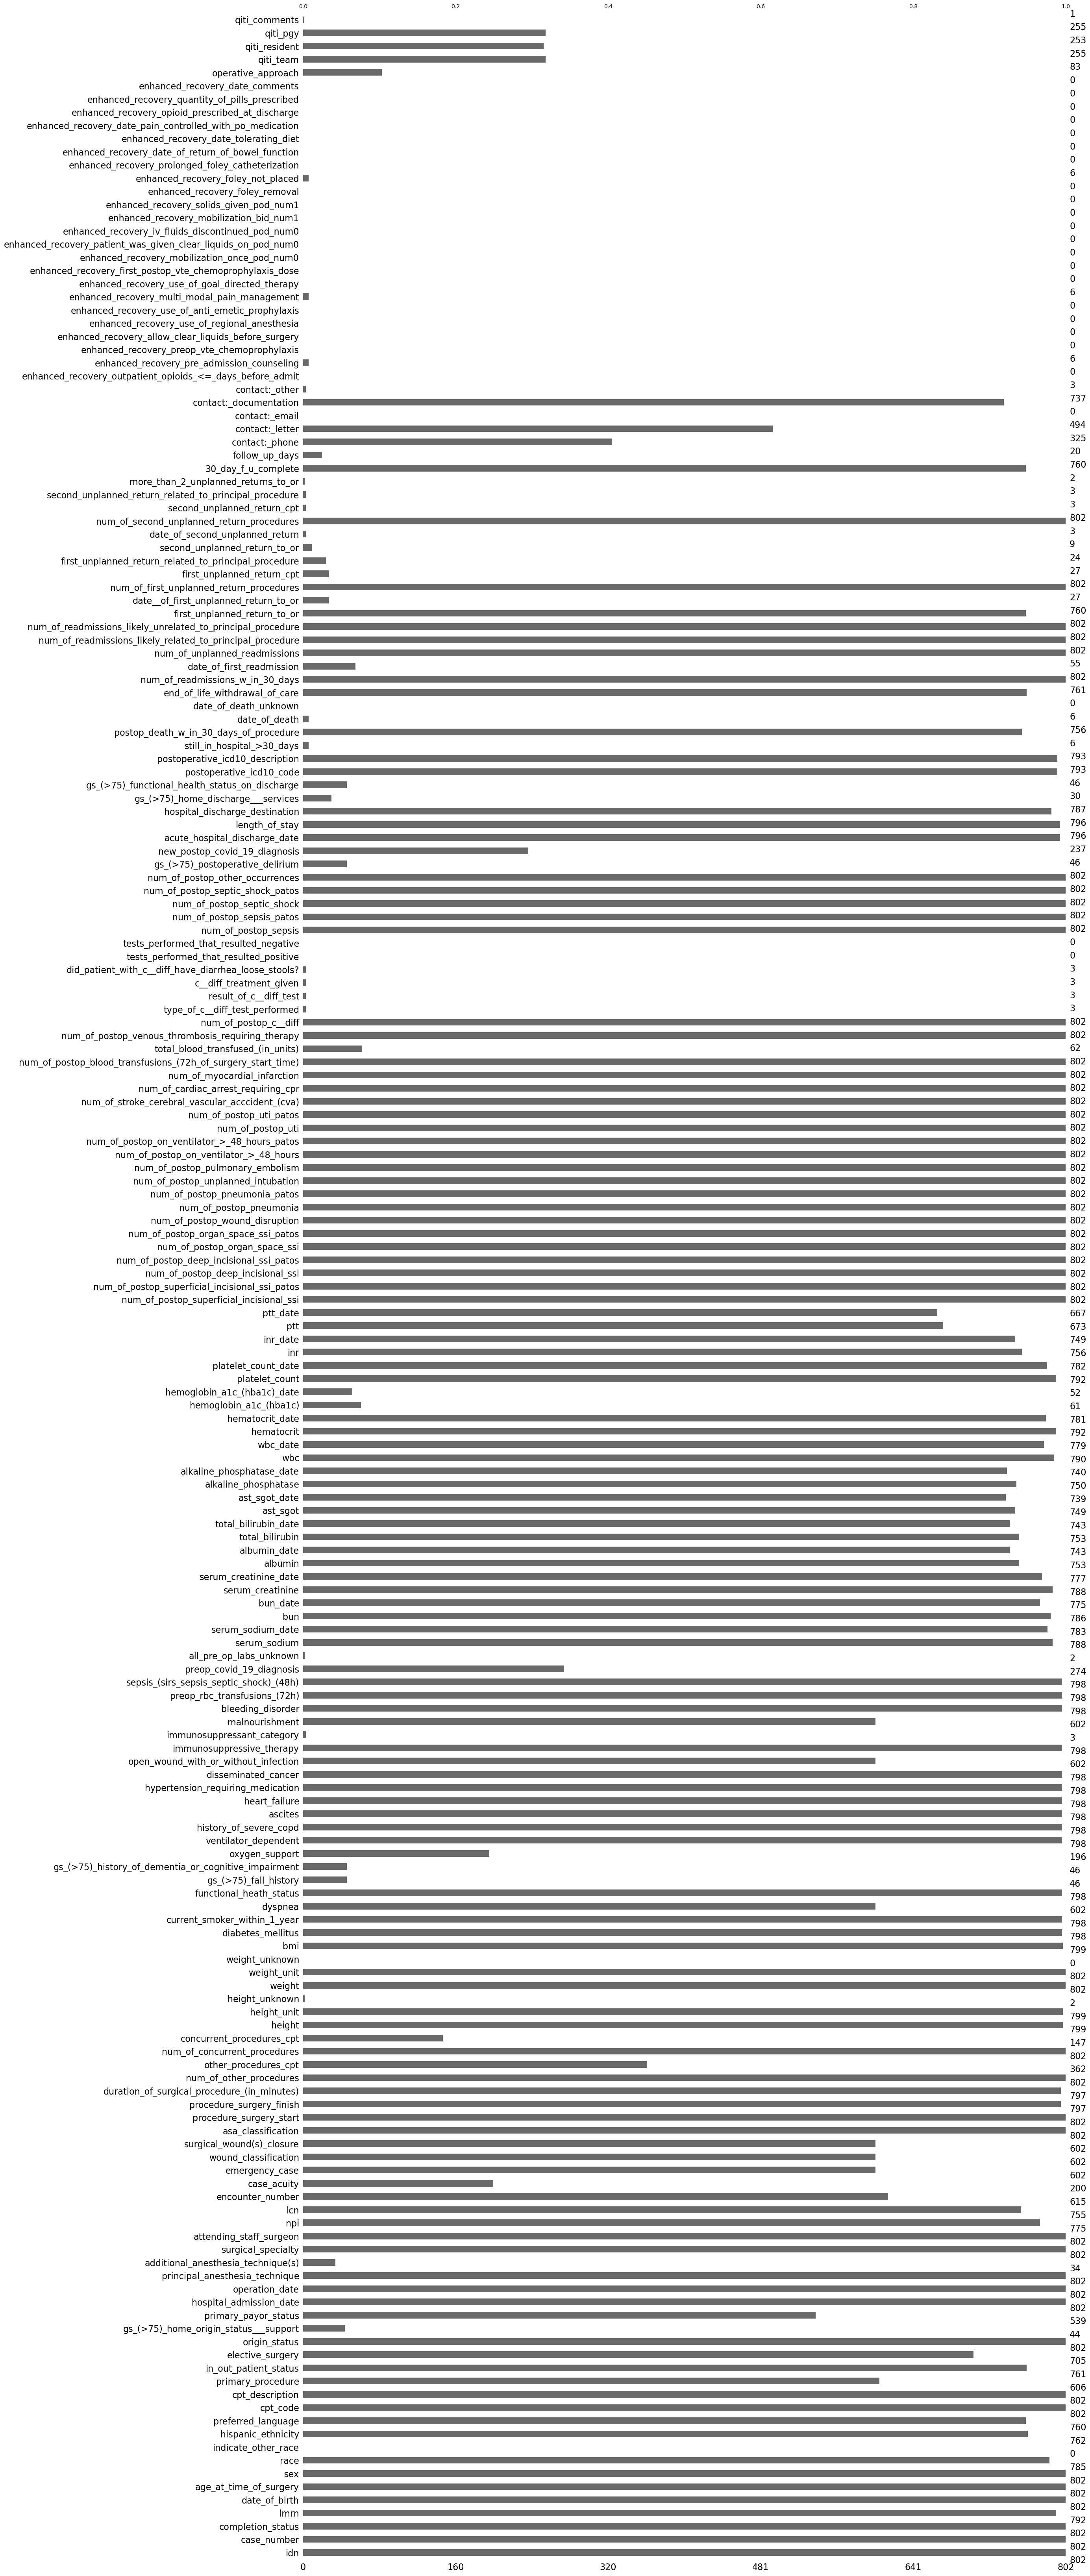

In [654]:
"""Visualize missing data"""

msno.bar(merged_colorectal)

In [655]:
%%capture

"""There appear to be four types of features in the dataset:

1) Demographic data: race, sex, age
2) Information about the surgery: open vs laproscopic, etc
3) Comorbidities, or diseases/ health conditions
4) Complications arising from the surgery

Let's perform some cleaning and EDA on each category."""

In [656]:
"""First figure out if any patients did not survive the procedure/do not have a LOS value"""

merged_colorectal[merged_colorectal['length_of_stay'].isnull()]['acute_hospital_discharge_date']

342    NaN
558    NaN
666    NaN
672    NaN
682    NaN
747    NaN
Name: acute_hospital_discharge_date, dtype: object

Looks like 6 patients do not have a LOS value nor a discharge date, so drop them.

In [657]:
merged_colorectal = merged_colorectal[merged_colorectal['length_of_stay'].notnull()]

In [658]:
merged_colorectal['hospital_discharge_destination'].value_counts(dropna = False)

Home                        537
Home/Permanent Residence    158
Skilled Care, Not Home       61
Other Facility               19
NaN                           9
Expired                       5
Facility Which was Home       4
Hospice                       2
Rehab                         1
Name: hospital_discharge_destination, dtype: int64

In [659]:
"""Drop patients who expired during/after surgery."""

merged_colorectal = merged_colorectal.query('hospital_discharge_destination != "Expired"')

In [660]:
merged_colorectal = merged_colorectal.reset_index()

In [661]:
px.box(x = merged_colorectal['hospital_discharge_destination'],
           y = merged_colorectal['length_of_stay'],
      points = "all")

In [662]:
"""Rename lengthy column names"""

merged_colorectal = merged_colorectal.rename(columns = {"age_at_time_of_surgery": 'age',
                                            "'sepsis_(sirs/sepsis/septic_shock)_(48h)'":'Sepsis',
                                            'num_of_postop_blood_transfusions_(72h_of_surgery_start_time)':'num_of_postop_blood_transfusions',
                                            'preop_rbc_transfusions_(72h)': 'preop_rbc_transfusions'})

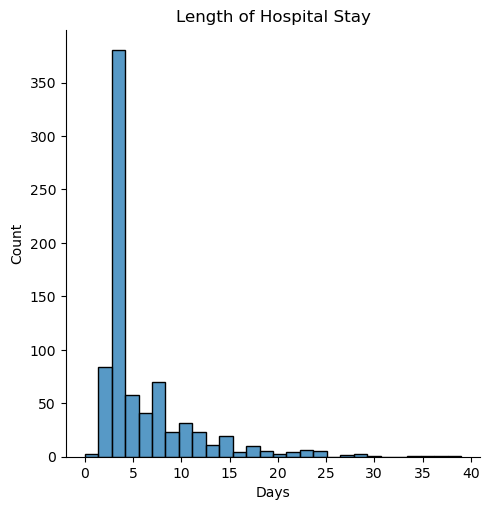

In [663]:
"""Examining the distribution of hospital length of stay."""

bins = int(np.sqrt(merged_colorectal.shape[0]))

sns.displot(merged_colorectal['length_of_stay'], bins = bins)
sns.despine()
plt.title('Length of Hospital Stay')
plt.xlabel('Days')
plt.show()

We have a distribution of counts, with a right skew, which is best fit by either a Poisson or negative binomial distribution. 

In [664]:
"""There is a patient with 0 days LOS. Given the nature of this procedure, this seems unlikely."""

merged_colorectal[merged_colorectal['length_of_stay'] == 0][['hospital_admission_date',
                                                                     'acute_hospital_discharge_date']]

hospital_admission_date acute_hospital_discharge_date
642              05/21/2021                    05/21/2021

While the dates of admission and discharge are the same, this patient is elderly (87 years old), and would almost
certainly have stayed in the hospital for at least one day. We will remove this record from the dataset.

In [665]:
merged_colorectal = merged_colorectal.drop(labels = 642)

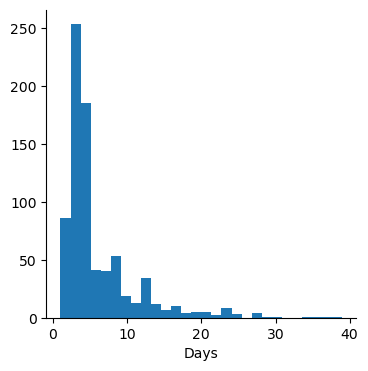

In [666]:
"""Examining the distribution of hospital length of stay."""
fig, axs = plt.subplots(figsize = (4,4))
bins = int(np.sqrt(merged_colorectal.shape[0]))
axs.hist(merged_colorectal['length_of_stay'], bins = bins)
sns.despine()
#plt.title('Length of Hospital Stay')
plt.xlabel('Days')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



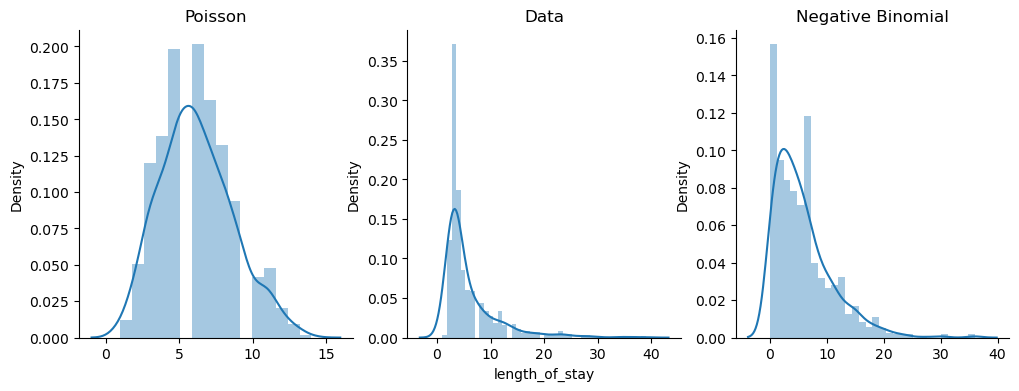

In [667]:
"""Generate simulated Poisson and negative binomial distributions based on parameters derived from our data.
The Poisson distribution has one parameter which describes both its mean and its variance. The binomial
distribution is overdispersed, such that the variance is a quadratic function of the mean and a dispersion parameter. 
Determinging which distribution best fits our data will aid our choice of model."""


# Simulated Poisson. The Poisson distribution has one parameter which describes both its mean and its variance
Poisson_sim = np.random.poisson(merged_colorectal['length_of_stay'].mean(),800)


# Simulate negative binomial distribution
mean = merged_colorectal['length_of_stay'].mean()
var = merged_colorectal['length_of_stay'].var()

n = mean**2 / (var - mean)
p = mean / var

NB_sim = np.random.negative_binomial(n,p,1000)

# plot distributions
fig, axes = plt.subplots(1,3, 
                         squeeze = False, 
                         figsize = (12,4))
sns.distplot(Poisson_sim, ax = axes[0][0])
axes[0][0].set_title('Poisson')
sns.distplot(merged_colorectal['length_of_stay'], ax = axes[0][1])
axes[0][1].set_title('Data')
sns.distplot(NB_sim, ax = axes[0][2])
axes[0][2].set_title('Negative Binomial')
sns.despine()
plt.show();

Both the Poisson and the negative binomial distributions peak around 5, with the majority of values falling between 1 and ~15, and have a rightward skew. However, the negative binomial distribution looks to be a better overall fit to the data, capturing more completely the tail than does the Poisson distribution. One problem with both fits is that they allow 0 values, but the minimum LOS is 1 day. 

In [668]:
"""To further substantiate our choice of model, let's examine our target variable, length of stay (LOS), for over-
dispersion. To do that, we will fit a negative binomial distribution to our data without any predictors."""

x = np.ones_like(merged_colorectal['length_of_stay'])
nb_model = sm.NegativeBinomial(merged_colorectal['length_of_stay'],x).fit()
print(nb_model.summary())

Optimization terminated successfully.
         Current function value: 2.724607
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
                     NegativeBinomial Regression Results                      
Dep. Variable:         length_of_stay   No. Observations:                  790
Model:               NegativeBinomial   Df Residuals:                      789
Method:                           MLE   Df Model:                            0
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:               5.260e-12
Time:                        22:46:09   Log-Likelihood:                -2152.4
converged:                       True   LL-Null:                       -2152.4
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8000      0.026     70.2

Alpha is the overdispersion parameter, and is 0.35 in our case. While small, the p-value indicates that it is statistically significant. We will therefore conclude that our data is more appropriately fit with a negative binomial distribution than a Poisson distribution.

In [669]:
%%capture
"""Cleaning and EDA on surgery type. 'In/Out-Patient_Status and CPT_Description' appear to be relevant columns."""

In [670]:
merged_colorectal['in_out_patient_status'].value_counts(dropna = False)

Inpatient     746
NaN            40
Outpatient      4
Name: in_out_patient_status, dtype: int64

Due to the substantial class imbalance, this feature will likely not be useful for modeling. 

In [671]:
"""CPT description"""

merged_colorectal['cpt_description'].value_counts(dropna = False)

Laparoscopy, surgical; colectomy, partial, with removal of terminal ileum with ileocolostomy                                                                                                               247
Laparoscopy, surgical; colectomy, partial, with anastomosis, with coloproctostomy (low pelvic anastomosis)                                                                                                 232
Laparoscopy, surgical; colectomy, partial, with anastomosis                                                                                                                                                100
Colectomy, partial, with removal of terminal ileum with ileocolostomy                                                                                                                                       50
Laparoscopy, surgical; colectomy, partial, with anastomosis, with coloproctostomy (low pelvic anastomosis) with colostomy                                                   

In [672]:
"""Open procedures involve making a single, large incision, and are the traditional surgical approach. Laparoscopic
surgery, in contrast, is a minimally invasive approach. It has been shown that recovery times are generally shorter
for laparoscopic procedures. 
Let's consolidate the column along an open vs. laparoscipic axis."""

merged_colorectal['open_or_laparoscopic'] =  np.where(merged_colorectal['cpt_description'].str.startswith('Laparoscopy'),
                                                     'Laparoscopic',
                                                     'Open')

In [673]:
merged_colorectal['open_or_laparoscopic'].value_counts(dropna = False)

Laparoscopic    668
Open            122
Name: open_or_laparoscopic, dtype: int64

<AxesSubplot:xlabel='open_or_laparoscopic', ylabel='length_of_stay'>

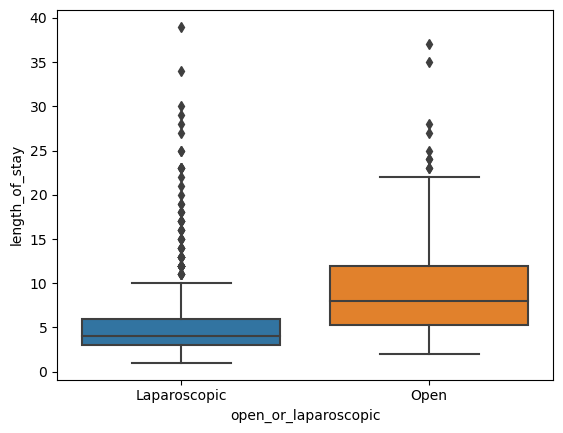

In [674]:
sns.boxplot(x = 'open_or_laparoscopic',
            y = 'length_of_stay',
            data = merged_colorectal)

In [675]:
"""Mann-Whitney U test comparison of median length of stay following open vs. laparoscopic colectomies."""

scipy.stats.mannwhitneyu(merged_colorectal[merged_colorectal['open_or_laparoscopic'] == 'Laparoscopic']['length_of_stay'],
                    merged_colorectal[merged_colorectal['open_or_laparoscopic'] == 'Open']['length_of_stay'])

MannwhitneyuResult(statistic=17224.5, pvalue=4.057317620249743e-25)

It appears as though patients undergoing laparoscopic colectomies have a statistically significant 
shorter length of stay.

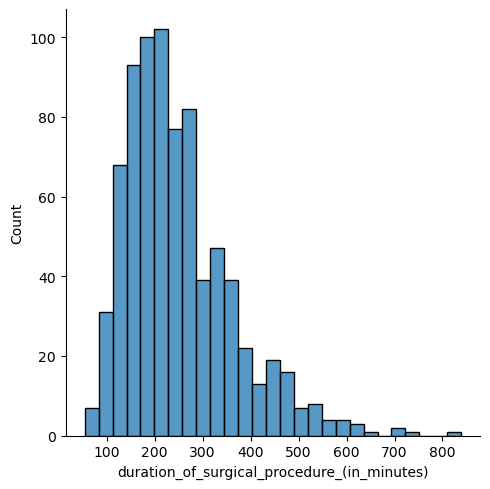

In [676]:
"""What does the distribution of surgery duration look like? """

sns.displot(x = 'duration_of_surgical_procedure_(in_minutes)',
            data = merged_colorectal)
sns.despine()

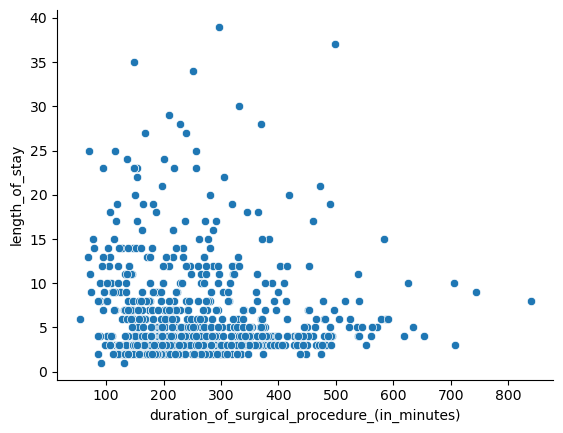

In [677]:
"""Is there an obvious relationship between duration of surgery and hospital length of stay?"""

sns.scatterplot(x = 'duration_of_surgical_procedure_(in_minutes)',
                 y = 'length_of_stay',
                 data = merged_colorectal)
sns.despine()

In [678]:
""" Let's quantify the correlation between duration of surgery and length of stay. Given the discrete, essentially 
ordinal nature of the length of stay variable, Kendall's tau, a rank-based test of correlation, is the appropriate 
choice."""

ktau = merged_colorectal['duration_of_surgical_procedure_(in_minutes)'].corr(merged_colorectal['length_of_stay'],
                                     method = 'kendall')
print(f" Kendall's tau correlation coefficient = {ktau}")

 Kendall's tau correlation coefficient = 0.03748815383085235


There is not a strong association between surgery duration and length of stay in our dataset. 

In [679]:
"""What is the breakdown of case acuity, that is, elective, urgent, or emergent, in the dataset? """

merged_colorectal['case_acuity'].value_counts(dropna = False)

NaN         598
Elective    172
Urgent       14
Emergent      6
Name: case_acuity, dtype: int64

598 cases have a missing acuity designation. There is an emergency case column, which may tell us if the cases are
emergent are not.

In [680]:


merged_colorectal['emergency_case'].value_counts(dropna = False)

No     598
NaN    192
Name: emergency_case, dtype: int64

The 598 null values in the 'case_acuity' columns are either elective or urgent.

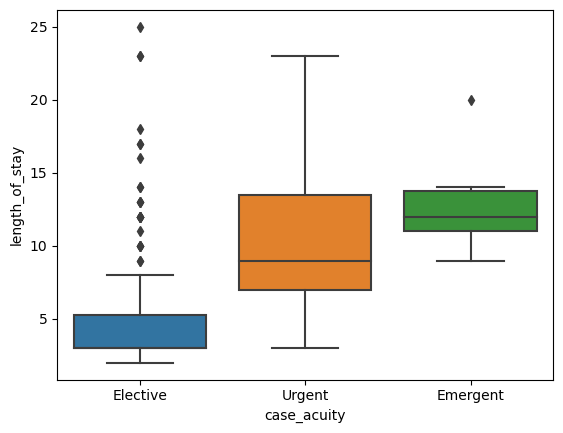

In [681]:
"""Visualize LOS by cause acuity"""

sns.boxplot(x = merged_colorectal['case_acuity'],
           y = merged_colorectal['length_of_stay']);

<AxesSubplot:>

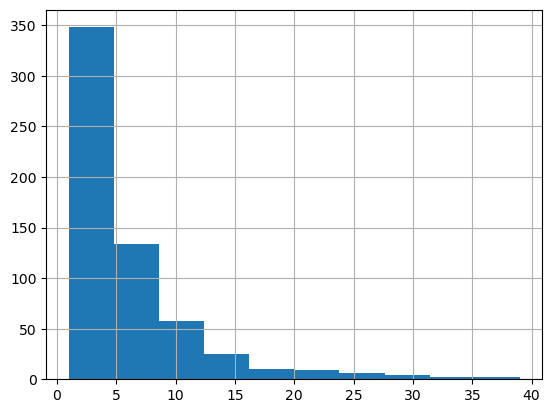

In [682]:
merged_colorectal[merged_colorectal['case_acuity'].isnull()]['length_of_stay'].hist()

<AxesSubplot:>

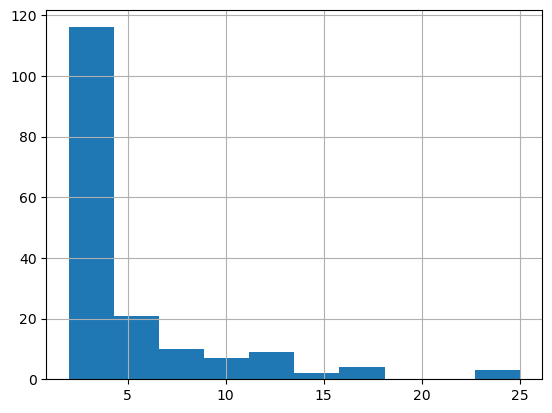

In [683]:
merged_colorectal[merged_colorectal['case_acuity']== 'Elective']['length_of_stay'].hist()

<AxesSubplot:>

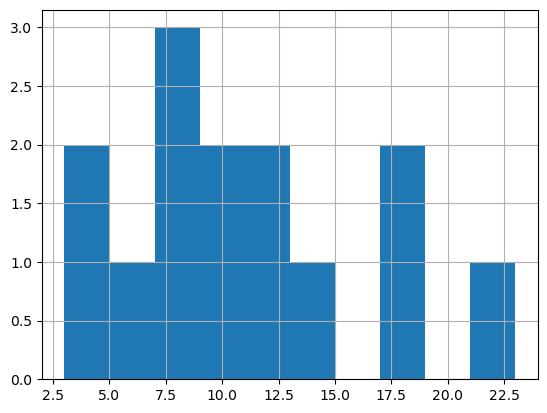

In [684]:
merged_colorectal[merged_colorectal['case_acuity']== 'Urgent']['length_of_stay'].hist()

In [685]:
merged_colorectal['case_acuity'].value_counts(dropna = False)

NaN         598
Elective    172
Urgent       14
Emergent      6
Name: case_acuity, dtype: int64

In [686]:
"""Based on the similarities between their distributions, and the numeric breakdown, I will consolidate the null 
values in case_acuity column with 'Elective'."""

merged_colorectal.case_acuity.fillna('Elective', inplace = True)

In [687]:
"""Owing to the small numbers and similar distributions of urgent and emergent cases, consolidate them"""

merged_colorectal.case_acuity = merged_colorectal.case_acuity.map({'Elective':'Elective','Urgent':'Urgent/Emergent','Emergent':'Urgent/Emergent'})

<AxesSubplot:xlabel='case_acuity', ylabel='length_of_stay'>

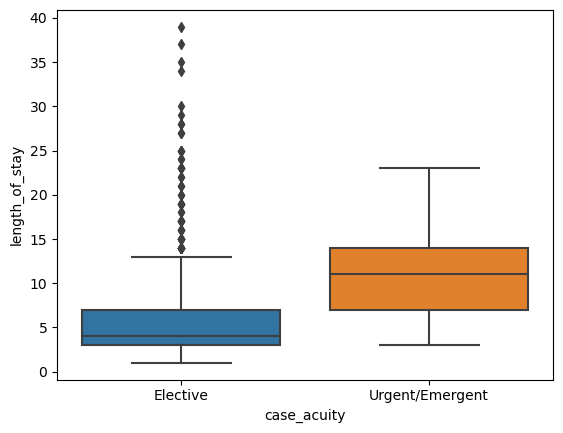

In [688]:
sns.boxplot(x = 'case_acuity',y = 'length_of_stay',data = merged_colorectal)

In [689]:
""" Functional health status describes whether a patient is functionally independent, or requires assistance to perform
the daily activities of life. It is therefore a readout of overall health, and may be predictive of length of stay."""

# Fix the typo in the original column name
merged_colorectal.rename(columns = {'functional_heath_status': 'functional_health_status'}, inplace = True)

In [690]:
merged_colorectal['functional_health_status'].value_counts(dropna = False)

Independent            730
Partially Dependent     47
Totally Dependent        7
Unknown                  3
NaN                      3
Name: functional_health_status, dtype: int64

In [691]:
"""Consolidate functional status designations"""

merged_colorectal['functional_health_status'] = merged_colorectal['functional_health_status'].map({'Independent':'Independent',
                                                                                           'Partially Dependent':'Partially Dependent',
                                                                                           'Totally Dependent':'Totally Dependent',
                                                                                           'Unknown:':np.nan})

In [692]:
merged_colorectal['functional_health_status'].value_counts(dropna = False)

Independent            730
Partially Dependent     47
Totally Dependent        7
NaN                      6
Name: functional_health_status, dtype: int64

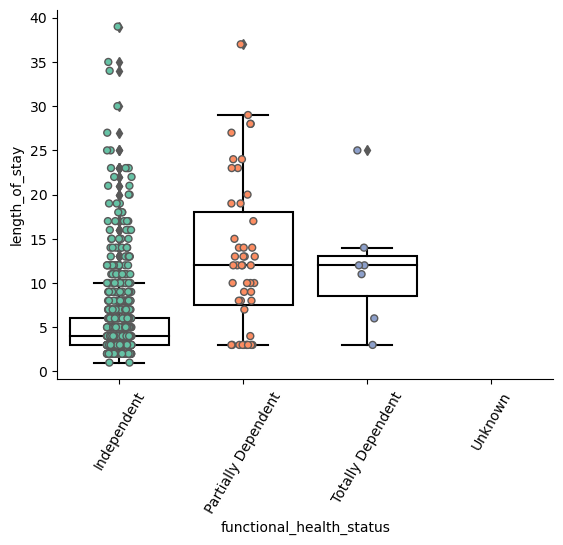

In [693]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'functional_health_status', 
            y = 'length_of_stay', 
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2',
           order = ['Independent','Partially Dependent','Totally Dependent','Unknown'])
sns.stripplot(x = 'functional_health_status', 
              y = 'length_of_stay', 
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              jitter = 0.1,
             order = ['Independent','Partially Dependent','Totally Dependent','Unknown'])
plt.xticks(rotation = 60)
sns.despine()
plt.show()

In [694]:
#Consolidate health status into functionally independent or dependent values

merged_colorectal['functionally_dpdt_or_ind'] = np.where(merged_colorectal['functional_health_status'].isin(['Partially Dependent','Totally Dependent']),
                                                                                                                 'Dependent',
                                                                                                                 'Independent')

In [695]:
merged_colorectal['functionally_dpdt_or_ind'].value_counts(dropna = False)

Independent    736
Dependent       54
Name: functionally_dpdt_or_ind, dtype: int64

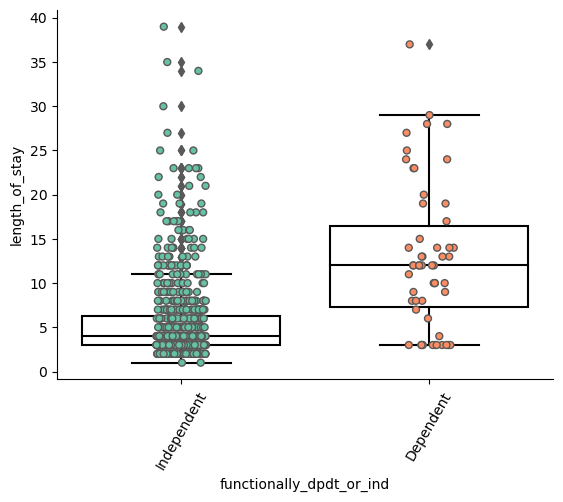

In [696]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'functionally_dpdt_or_ind', 
            y = 'length_of_stay', 
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2',
            order = ['Independent','Dependent'])
sns.stripplot(x = 'functionally_dpdt_or_ind', 
              y = 'length_of_stay', 
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              jitter = 0.1,
              order = ['Independent','Dependent'])
plt.xticks(rotation = 60)
sns.despine()
plt.show()

In [697]:
"""Mann-Whitney U-test to test whether difference in independent and dependent groups is statistically significant."""

scipy.stats.mannwhitneyu(merged_colorectal[merged_colorectal['functionally_dpdt_or_ind']=='Dependent']['length_of_stay'].dropna(), 
                        merged_colorectal[merged_colorectal['functionally_dpdt_or_ind']=='Independent']['length_of_stay'].dropna())

MannwhitneyuResult(statistic=31189.0, pvalue=9.886070064041505e-13)

Functional dependence is associated with a (statistically-significant) longer length of stay.

In [698]:
"""On which day of the week were surgeries performed? This has shown to be a factor in determining length of stay."""

# Get the data type and format of the 'Operation_Date' column'
merged_colorectal['operation_date'].head()

0    11/08/2016
1    11/01/2016
2    11/01/2016
3    11/04/2016
4    11/05/2016
Name: operation_date, dtype: object

In [699]:
"""Create operation month and day-of-week columns"""

#Convert operation date column to datetime type
merged_colorectal['operation_date'] = pd.to_datetime(merged_colorectal['operation_date'])

#Extract month
merged_colorectal['operation_month'] = merged_colorectal['operation_date'].dt.month

# Create a dictionary to map numeric months to proper nouns (January, February, etc.)
months_dict = {i:j for i,j in enumerate(list(calendar.month_name)) if i != 0}
merged_colorectal['operation_month'] = merged_colorectal['operation_month'].map(months_dict)


# Repeat the above procedure for day of operation
merged_colorectal['operation_dow'] = merged_colorectal['operation_date'].dt.dayofweek

days_dict = {i:j for i,j in enumerate(list(calendar.day_name))}
merged_colorectal['operation_dow'] = merged_colorectal['operation_dow'].map(days_dict)


In [700]:
dow = merged_colorectal.groupby(by = 'operation_dow')['length_of_stay'].agg([np.median,np.size])
dow = dow.reindex(['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday'])
dow

median  size
operation_dow              
Monday            5.0    73
Tuesday           3.0   193
Wednesday         6.0    67
Thursday          4.0   236
Friday            4.0   207

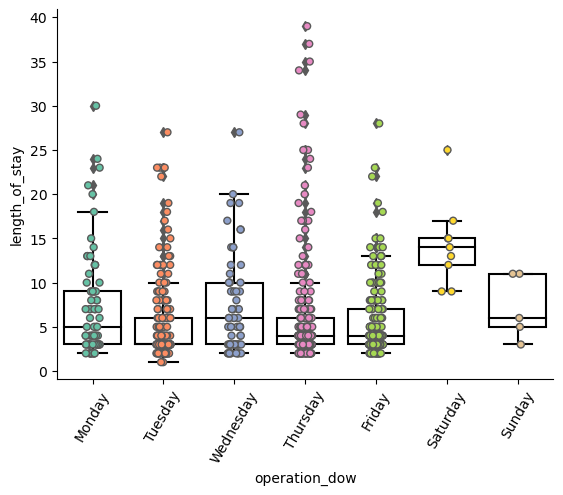

In [701]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'operation_dow', 
            y = 'length_of_stay', 
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2',
            order = [day for day in days_dict.values()])
sns.stripplot(x = 'operation_dow', 
              y = 'length_of_stay', 
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              order = [day for day in days_dict.values()],
              jitter = 0.1)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

There is no systematic variation in length of stay based on the day of the week of the procedure.

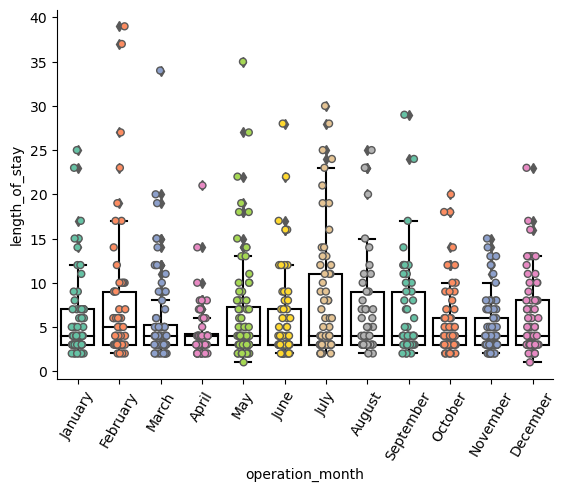

In [702]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'operation_month', 
            y = 'length_of_stay', 
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2',
            order = [month for month in months_dict.values()])
sns.stripplot(x = 'operation_month', 
              y = 'length_of_stay', 
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              order = [month for month in months_dict.values()],
              jitter = 0.15)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

There is no systematic variation in length of stay based on the month of the operation.

In [703]:
%%capture
"""Cleaning and EDA on demographic features"""

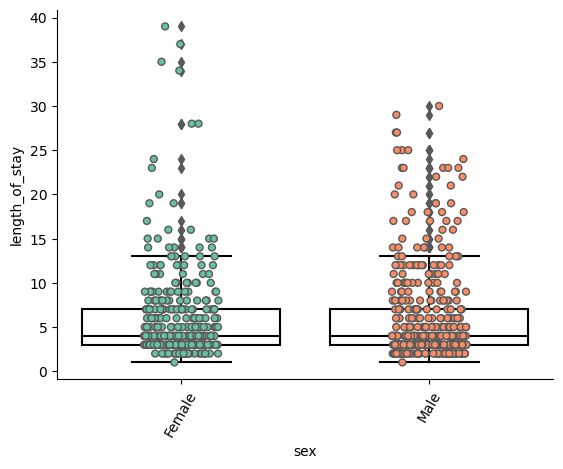

In [704]:
"""Is there a difference in length of stay between male and female patients?"""

props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'sex', 
            y = 'length_of_stay', 
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2')
sns.stripplot(x = 'sex', 
              y = 'length_of_stay', 
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              jitter = 0.15)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

There does not appear to be a difference in length of stay between the sexes

In [705]:
"""What is the racial makeup of the patient population?"""

merged_colorectal['race'].value_counts(dropna = False)

Asian                               263
White                               219
Unknown/Not Reported                205
Black or African American            85
NaN                                  17
American Indian or Alaska Native      1
Name: race, dtype: int64

In [706]:
"""Is unknown/unreported race data present elsewhere?"""

merged_colorectal['hispanic_ethnicity'].value_counts()

No         542
Yes        173
Unknown     36
Name: hispanic_ethnicity, dtype: int64

In [707]:
merged_colorectal[(merged_colorectal['race']=='Unknown/Not Reported') & (merged_colorectal['hispanic_ethnicity'] == 'Yes')]

index         idn  case_number completion_status          lmrn  \
2        3     4024633       112107          Complete  4.024633e+06   
5        6     4026403       112135          Complete  4.026403e+06   
9       10     4023853       112159          Complete  4.023853e+06   
47      48     4043863       112466          Complete  4.043863e+06   
50      51     3017465       112552          Complete  3.017465e+06   
..     ...         ...          ...               ...           ...   
762    773  1200351375       132176          Complete  1.200351e+09   
764    775  1010843281       132210          Complete  1.010843e+09   
766    777  1002286853       132229          Complete  1.002287e+09   
768    779  1010552952       132235          Complete  1.010553e+09   
770    781  1205549257       132309          Complete  1.205549e+09   

    date_of_birth    age     sex                  race  indicate_other_race  \
2      11/07/1960  55.98    Male  Unknown/Not Reported                  NaN   
5      12/04/1973  42.93    Male  Unknown/Not Reported                  NaN   
9      10/07/1948  68.09  Female  Unknown/Not Reported                  NaN   
47     09/20/1939  77.29    Male  Unknown/Not Reported                  NaN   
50     05/14/1952  64.68    Male  Unknown/Not Reported                  NaN   
..            ...    ...     ...                   ...                  ...   
762    06/06/1965  56.82  Female  Unknown/Not Reported                  NaN   
764    09/30/1979  42.51  Female  Unknown/Not Reported                  NaN   
766    10/23/1962  59.46    Male  Unknown/Not Reported                  NaN   
768    04/16/1991  30.98    Male  Unknown/Not Reported                  NaN   
770    05/01/1954  67.97    Male  Unknown/Not Reported                  NaN   

     ... enhanced_recovery_date_comments operative_approach  qiti_team  \
2    ...                             NaN                NaN          D   
5    ...                             NaN                NaN          D   
9    ...                             NaN                NaN          D   
47   ...                             NaN                NaN          D   
50   ...                             NaN                NaN          B   
..   ...                             ...                ...        ...   
762  ...                             NaN       Laparoscopic        NaN   
764  ...                             NaN       Laparoscopic        NaN   
766  ...                             NaN       Laparoscopic        NaN   
768  ...                             NaN       Laparoscopic        NaN   
770  ...                             NaN       Laparoscopic        NaN   

        qiti_resident qiti_pgy qiti_comments open_or_laparoscopic  \
2       Ourian, Ariel     PGY5           NaN         Laparoscopic   
5       Ourian, Ariel     PGY5           NaN         Laparoscopic   
9    Colakoglu, Salih     PGY5           NaN         Laparoscopic   
47   Colakoglu, Salih     PGY5           NaN         Laparoscopic   
50   Shuchleib, Ariel     PGY5           NaN                 Open   
..                ...      ...           ...                  ...   
762               NaN      NaN           NaN         Laparoscopic   
764               NaN      NaN           NaN         Laparoscopic   
766               NaN      NaN           NaN         Laparoscopic   
768               NaN      NaN           NaN         Laparoscopic   
770               NaN      NaN           NaN         Laparoscopic   

    functionally_dpdt_or_ind operation_month operation_dow  
2                Independent        November       Tuesday  
5                Independent        November       Tuesday  
9                Independent        November      Thursday  
47               Independent         January      Thursday  
50               Independent         January     Wednesday  
..                       ...             ...           ...  
762              Independent           April        Friday

In [708]:
%%capture

"""There are 141 instances of patients who labeled themselves as 'unknown race' but of hispanic 
ethnicity. Let's treat these as a separate, 'Hispanic', racial group."""

merged_colorectal['race'] = np.where((merged_colorectal['race'] == 'Unknown/Not Reported') & (merged_colorectal['hispanic_ethnicity'] == 'Yes'),
                                     'Hispanic',
                                     merged_colorectal['race'])

In [709]:
merged_colorectal['race'].value_counts(dropna = False)

Asian                               263
White                               219
Hispanic                            141
Black or African American            85
Unknown/Not Reported                 64
NaN                                  17
American Indian or Alaska Native      1
Name: race, dtype: int64

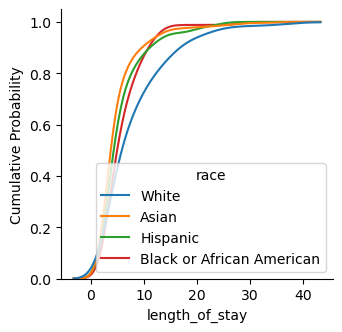

In [710]:
"""Do some racial/ethnic groups have longer LOS than others? """
fig, axs = plt.subplots(figsize = (3.5,3.5))
sns.kdeplot(data = merged_colorectal[~merged_colorectal['race'].isin(['Unknown/Not Reported','American Indian or Alaska Native'])], 
                           x = "length_of_stay", 
                           hue = "race",
            cumulative = True, 
            common_norm = False, 
            common_grid = True,
)
axs.set_xlabel('length_of_stay')
axs.set_ylabel('Cumulative Probability')
sns.despine();

Self-identified white patients appear to have longer LOS than other groups whereas elf-identified asian patients appear to have the shortest.

In [711]:
"""Is there a relationship between preferred language and length of stay?"""
merged_colorectal['preferred_language'].value_counts(dropna = False)

en_US    723
NaN       41
es        24
zh         2
Name: preferred_language, dtype: int64

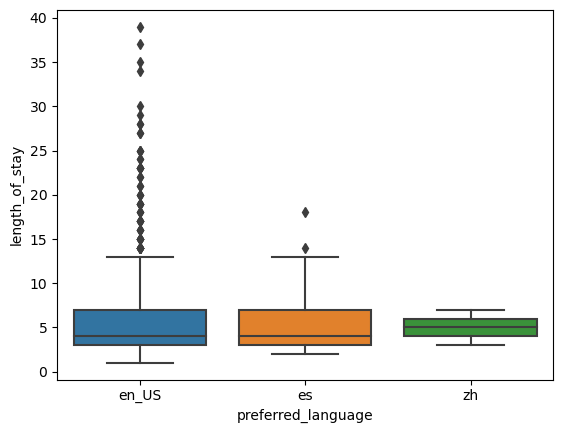

In [712]:
sns.boxplot(x = 'preferred_language',
            y = 'length_of_stay',
            data = merged_colorectal);

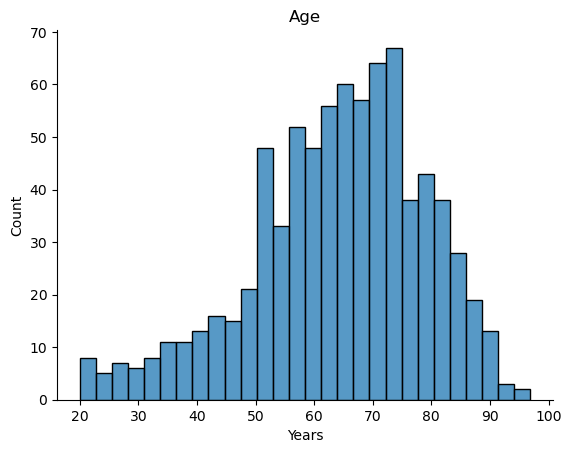

In [713]:
"""What is the age makeup of the patient population?"""

sns.histplot(x = merged_colorectal['age'], 
            bins = int(np.sqrt(merged_colorectal.shape[0])))
sns.despine()
plt.title('Age')
plt.xlabel('Years')

plt.show()


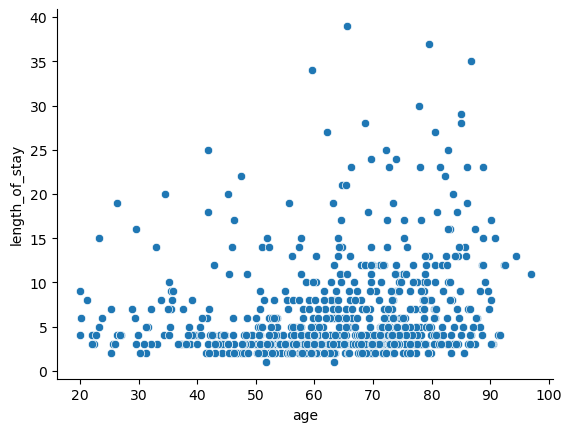

In [714]:
"""Is there a relationship between length of stay and age at time of surgery?"""

sns.scatterplot(x = merged_colorectal['age'],
            y = merged_colorectal['length_of_stay'])
sns.despine()
plt.show()


In [715]:
""" Kendall's tau calculation to quantify correlation between age and LOS."""

ktau = merged_colorectal['age'].corr(merged_colorectal['length_of_stay'],
                                     method = 'kendall')
print(f"Kendall's tau correlation coefficient = {ktau}")

Kendall's tau correlation coefficient = 0.14972048398245244


It appears as though age is weakly positively correlated with length of stay. 

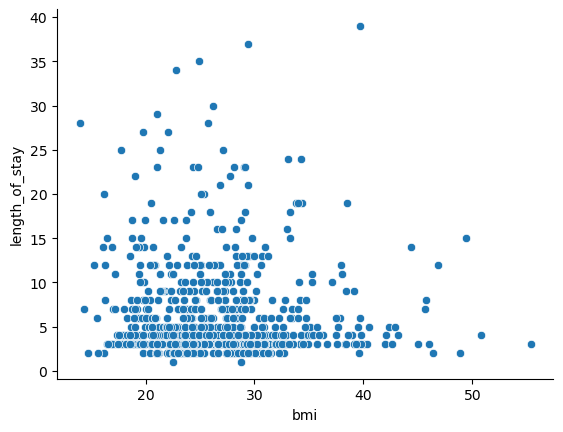

Kendall's tau correlation coefficient = -0.027747277009721082


In [716]:
"""Does body mass index, or BMI, correlate with length of stay? Increased BMI, especially at the level of obesity,
is associated with poorer health outcomes, generally, and has been linked to longer length of stay."""

sns.scatterplot(x = merged_colorectal['bmi'],
            y = merged_colorectal['length_of_stay'])
sns.despine()
plt.show()

ktau = merged_colorectal['bmi'].corr(merged_colorectal['length_of_stay'],
                                     method = 'kendall')

print(f"Kendall's tau correlation coefficient = {ktau}")

There is no obvious correlation between BMI and length of stay.

In [717]:
"""Does insurance payor status effect length of stay?"""

merged_colorectal['primary_payor_status'].value_counts(dropna = False)

NaN                  260
Medicare             245
Medicaid             164
Private insurance    116
Other                  3
Self-pay               2
Name: primary_payor_status, dtype: int64

There are 262 missing values, but let's see if there's anything interesting in the data

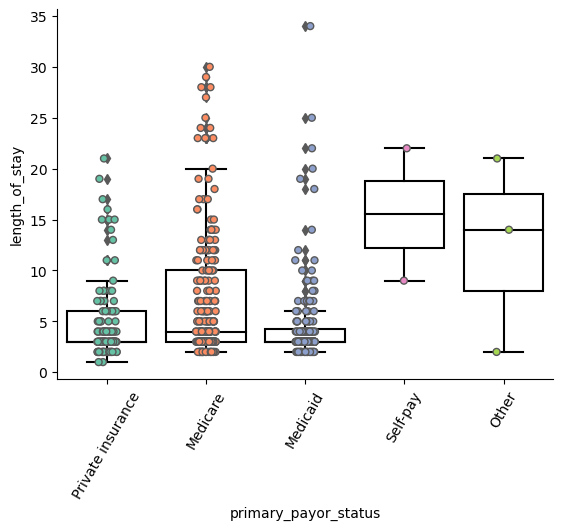

In [718]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'primary_payor_status', 
            y = 'length_of_stay',
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2')
sns.stripplot(x = 'primary_payor_status', 
              y = 'length_of_stay',
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

In [719]:
merged_colorectal.groupby(by = 'primary_payor_status')['length_of_stay'].agg([np.median, np.size])

median  size
primary_payor_status              
Medicaid                 3.0   164
Medicare                 4.0   245
Other                   14.0     3
Private insurance        3.0   116
Self-pay                15.5     2

There is a difference of 1 day in median length of stay between medicare patients and the the various insurance classes for which data is present.  There is higher variance in the Medicare group as well.

In [720]:
""" Comorbidities are severe medical conditions that negatively impact health and, potentially, length of stay.""" 

#Columns containing information related to co-morbidities.
comorb_cols = ['ventilator_dependent',
 'history_of_severe_copd',
 'ascites', 
 'heart_failure',
 'sepsis_(sirs_sepsis_septic_shock)_(48h)',
 'hypertension_requiring_medication',
 'disseminated_cancer',
 'immunosuppressive_therapy',
 'malnourishment',
 'bleeding_disorder',
 'preop_rbc_transfusions',
 'preop_covid_19_diagnosis', 
 'diabetes_mellitus',
 'current_smoker_within_1_year',
 'dyspnea']

# Display missing values
merged_colorectal[comorb_cols].isnull().sum()

ventilator_dependent                         3
history_of_severe_copd                       3
ascites                                      3
heart_failure                                3
sepsis_(sirs_sepsis_septic_shock)_(48h)      3
hypertension_requiring_medication            3
disseminated_cancer                          3
immunosuppressive_therapy                    3
malnourishment                             192
bleeding_disorder                            3
preop_rbc_transfusions                       3
preop_covid_19_diagnosis                   524
diabetes_mellitus                            3
current_smoker_within_1_year                 3
dyspnea                                    192
dtype: int64

In [721]:
comorb_cols.remove('preop_covid_19_diagnosis')

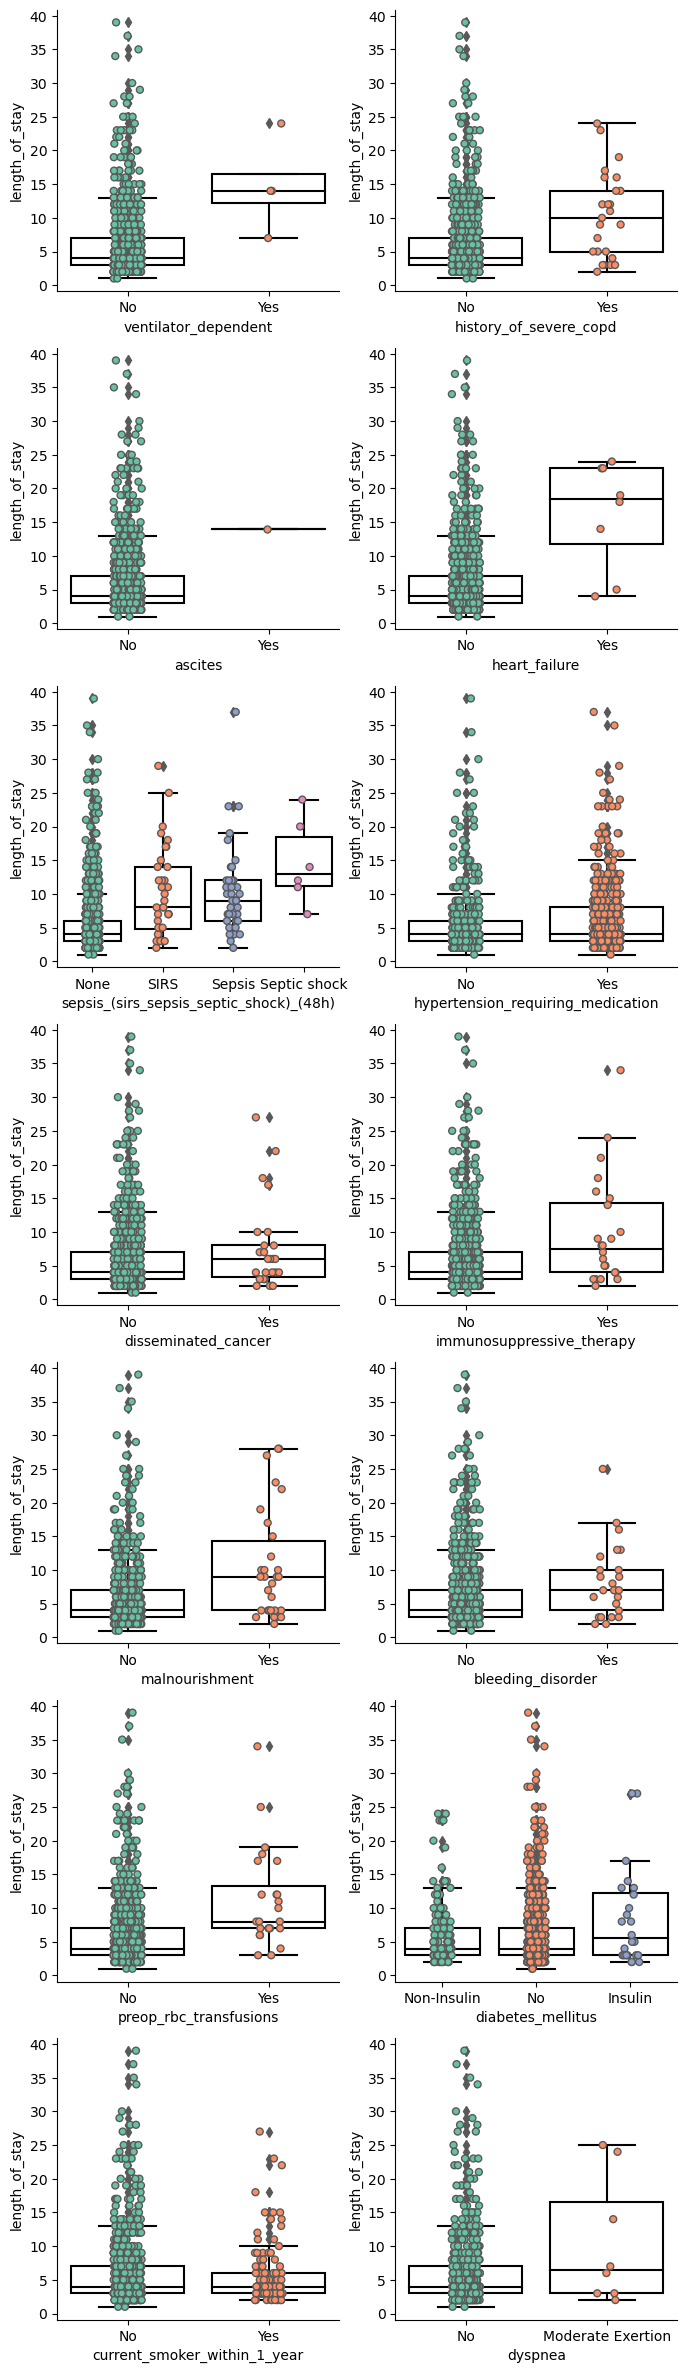

In [722]:
fig, axs = plt.subplots(nrows = 7, ncols = 2,figsize = (8,30))
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
for col, ax in zip(comorb_cols, axs.ravel()):
    sns.stripplot(x = col, y = 'length_of_stay', 
                  data = merged_colorectal,
                  ax = ax,
                  linewidth = 1,
                  jitter = 0.1,
                  palette = 'Set2')
    sns.boxplot(x = col, y = 'length_of_stay', 
                  data = merged_colorectal,
                  ax = ax,
                  palette = 'Set2',
                  **props)
    sns.despine()

In [723]:
"""Because 'SIRS' and 'Sepsis' subcategories of the Sepsis variable have similar distributions, let's consolidate them 
in order to make a statistically robust comparison between presence and absence."""

merged_colorectal['has_sepsis'] = np.where(merged_colorectal['sepsis_(sirs_sepsis_septic_shock)_(48h)'] == 'None',
                                          'No',
                                          'Yes')

#Update list of comorbidity columns
comorb_cols.append('has_sepsis')

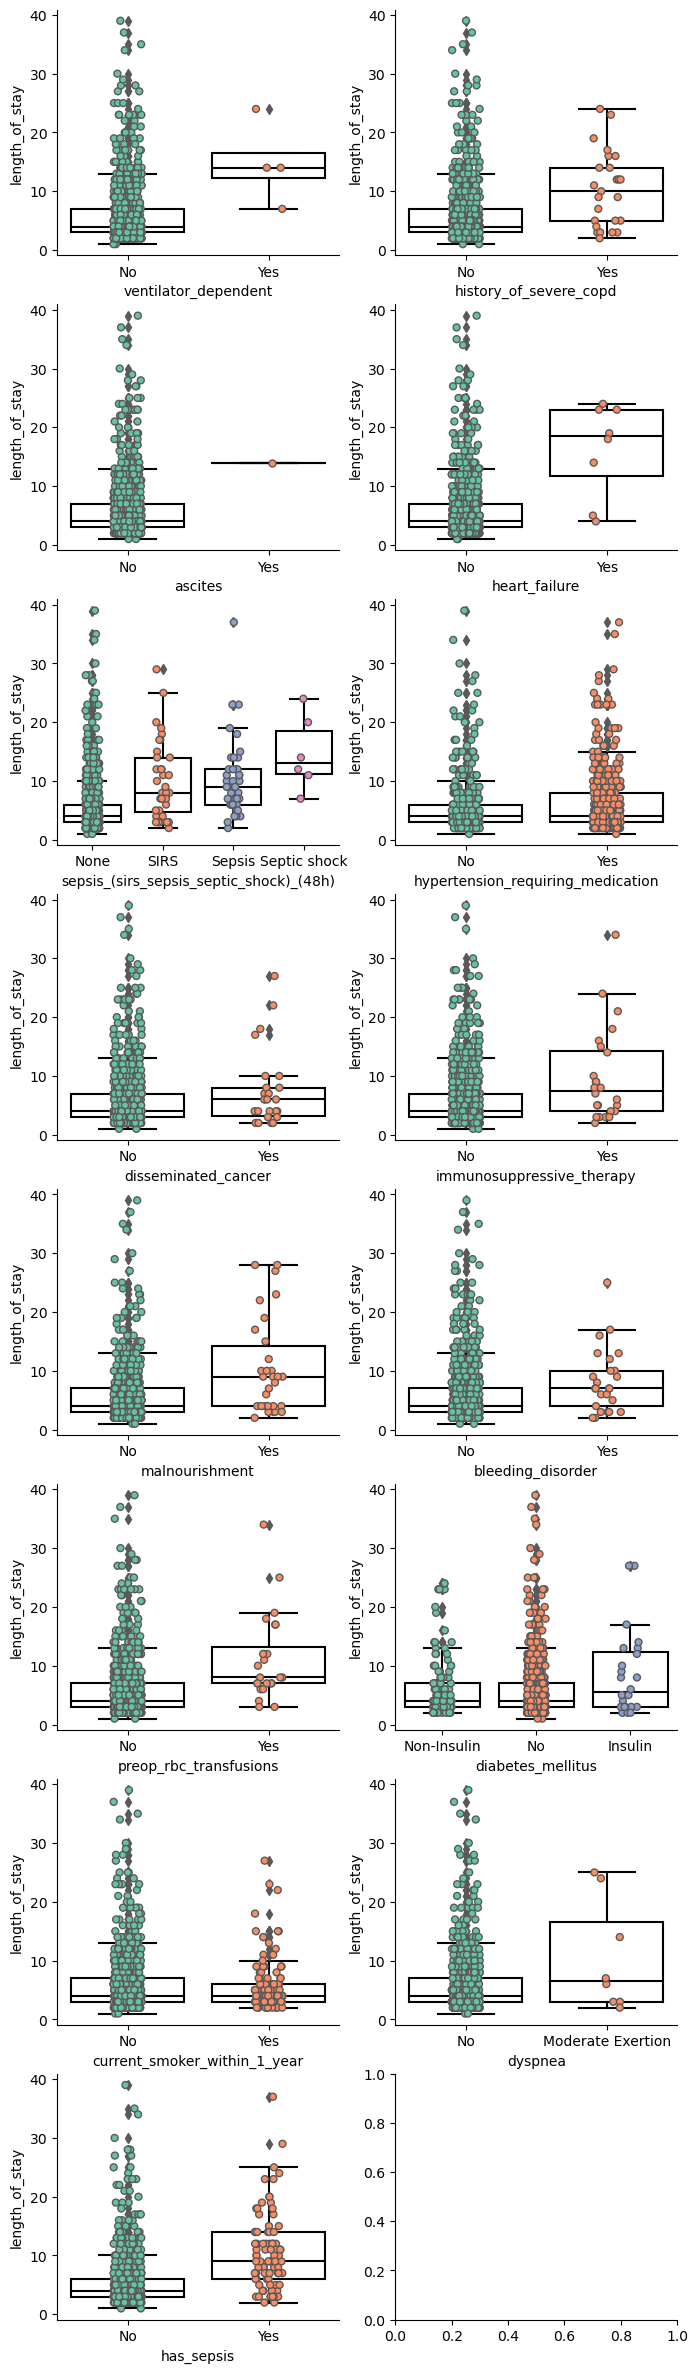

In [724]:
fig, axs = plt.subplots(nrows=8, ncols=2,figsize = (8,30))
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
for col, ax in zip(comorb_cols, axs.ravel()):
    sns.stripplot(x = col, y = 'length_of_stay', 
                  data = merged_colorectal,
                  ax = ax,
                  linewidth = 1,
                  jitter = 0.1,
                  palette = 'Set2')
    sns.boxplot(x = col, y = 'length_of_stay', 
                  data = merged_colorectal,
                  ax = ax,
                  palette = 'Set2',
                  **props)
    sns.despine()

The presence of each comorbidity increase LOS.

In [725]:
"""Charlson score is a metric for the severity of comorbidities. It might be a helpful summary variable for the model.
"""

charlson_cols = ['heart_failure',
                 'history_of_severe_copd',
                 'diabetes_mellitus',
                 'disseminated_cancer']

In [726]:
def Charlson(heart_failure, history_of_severe_copd, diabetes, disseminated_cancer):
    score = 0
    if heart_failure == 'Yes':
        score += 1
    elif history_of_severe_copd == 'Yes':
        score += 1
    elif diabetes == 'Non-Insulin' or diabetes == 'Insulin':
        score += 1
    elif disseminated_cancer == 'Yes':
        score += 6
    return score

In [727]:
merged_colorectal['charlson'] = merged_colorectal.apply(lambda row: Charlson(row['heart_failure'],
                                                                             row['history_of_severe_copd'],
                                                                             row['diabetes_mellitus'],
                                                                             row['disseminated_cancer']), axis = 1)

In [728]:
px.box(x = merged_colorectal['charlson'], y = merged_colorectal['length_of_stay'], points = 'all')

While there isn't a difference in median LOS between Charlson score groups, variance is larger for the higher-scoring
groups. 

In [729]:
"""Prior to surgery, blood is drawn to test critical markers of organ function and overall health. How do lab test 
values relate to length of stay?"""

# Columns containing lab test data
lab_tests = ['serum_sodium',
 'bun',
 'serum_creatinine',
 'albumin',
 'total_bilirubin',
 'ast_sgot',
 'alkaline_phosphatase',
 'wbc',
 'hematocrit',
 'hemoglobin_a1c_(hba1c)',
 'platelet_count',
 'inr',
 'ptt']

In [730]:
# Check for missing values
merged_colorectal[lab_tests].isnull().sum()

serum_sodium               14
bun                        16
serum_creatinine           14
albumin                    48
total_bilirubin            49
ast_sgot                   53
alkaline_phosphatase       52
wbc                        12
hematocrit                 10
hemoglobin_a1c_(hba1c)    731
platelet_count             10
inr                        45
ptt                       128
dtype: int64

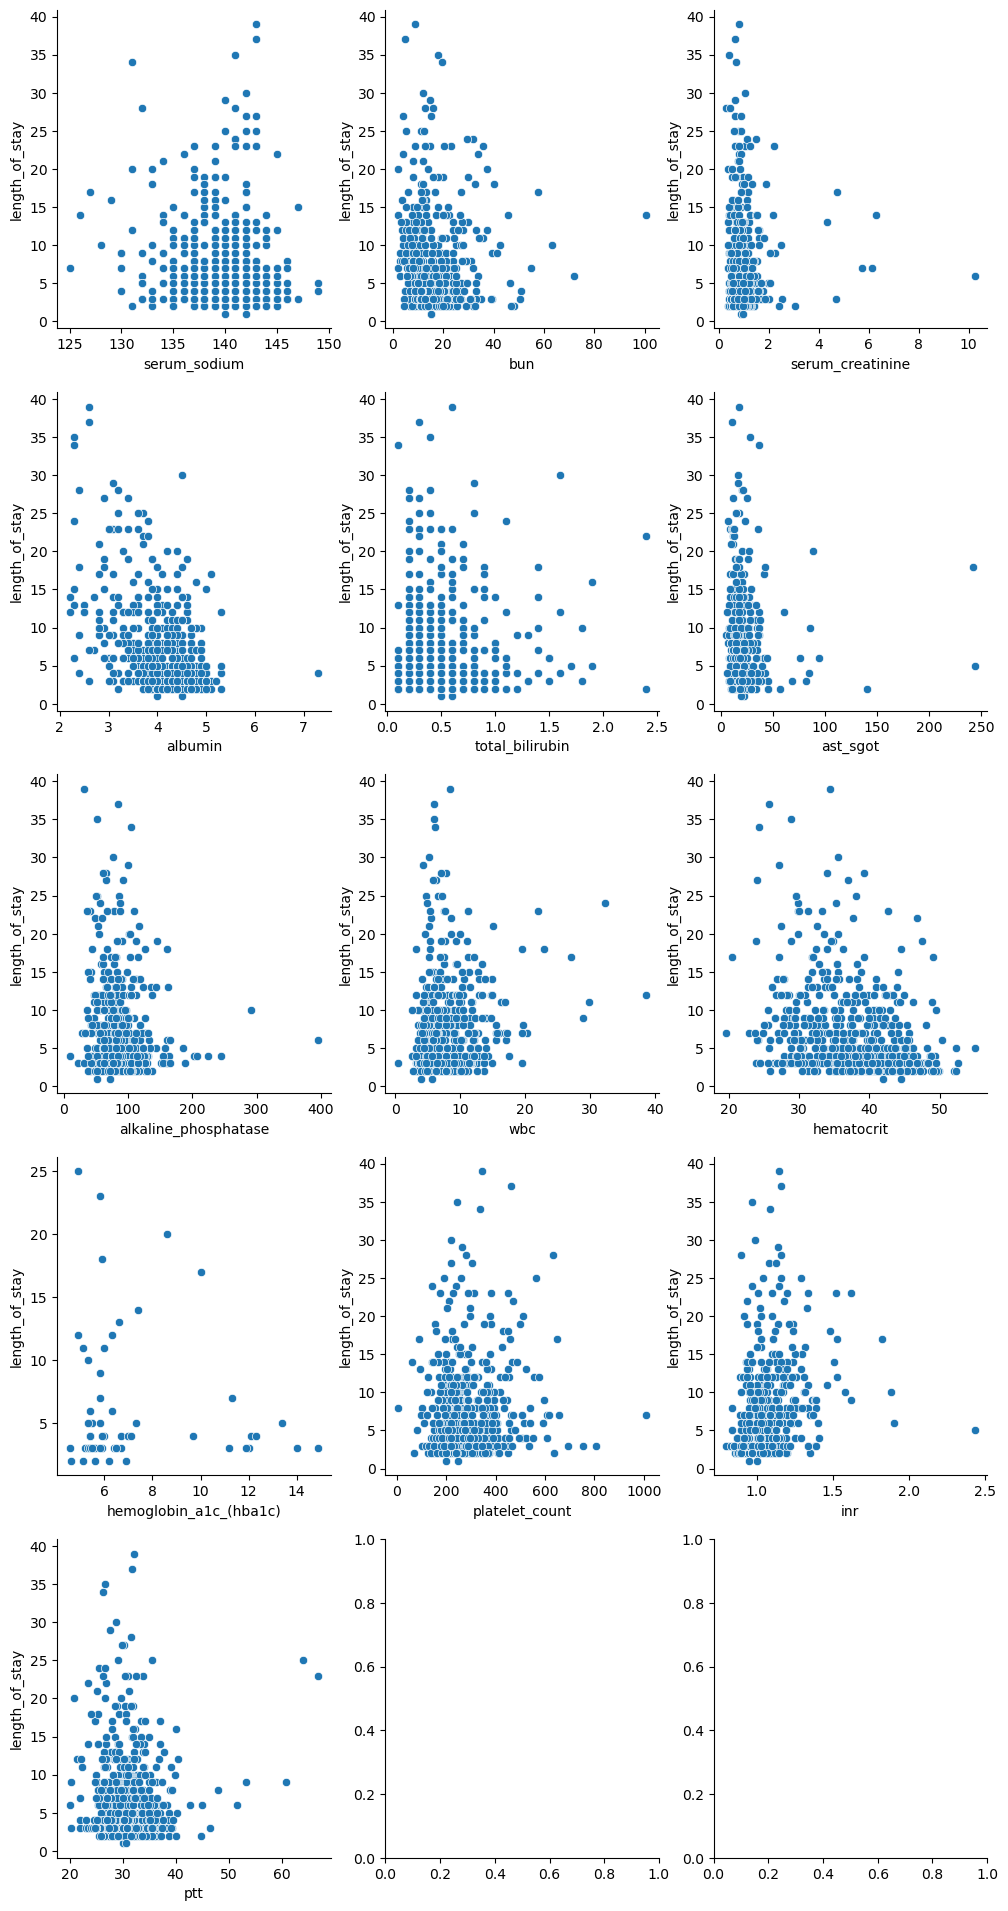

In [731]:
"""How do lab values correlate with LOS?"""

fig, axs = plt.subplots(nrows=5, ncols=3,figsize = (12,24))

for col, ax in zip(lab_tests, axs.ravel()):
    sns.scatterplot(x = col, y = 'length_of_stay', data = merged_colorectal,ax = ax)
    sns.despine()

In [732]:
"""Determine the correlation coefficients between each lab value and length of stay. Kendall's tau is a nonparametric
measure of correlation based on ranks."""

merged_colorectal[lab_tests].corrwith(merged_colorectal['length_of_stay'],
                                     method = 'kendall')

serum_sodium             -0.130471
bun                      -0.103308
serum_creatinine         -0.027588
albumin                  -0.294148
total_bilirubin           0.012224
ast_sgot                 -0.085006
alkaline_phosphatase      0.013067
wbc                       0.138420
hematocrit               -0.241999
hemoglobin_a1c_(hba1c)    0.043648
platelet_count            0.081615
inr                       0.274781
ptt                      -0.025413
dtype: float64

Conventionally, values close to and above +-0.3 are evidence of correlation. Accordingly, albumin, hematocrit, and INR
are the likeliest predictors of length of stay. 

    Albumin is a marker of overall health, and higher levels have been linked to shorter length of stay following surgery.

    Hematocrit is the percentage by volume of blood cells, and effects oxygenation of the tissues. 

    INR, or international normalized ratio, indicates how long it takes for blood to clot. The higher the value, the longer the clotting time. 

Given what these three values indicate, their correlation with length of stay makes sense.

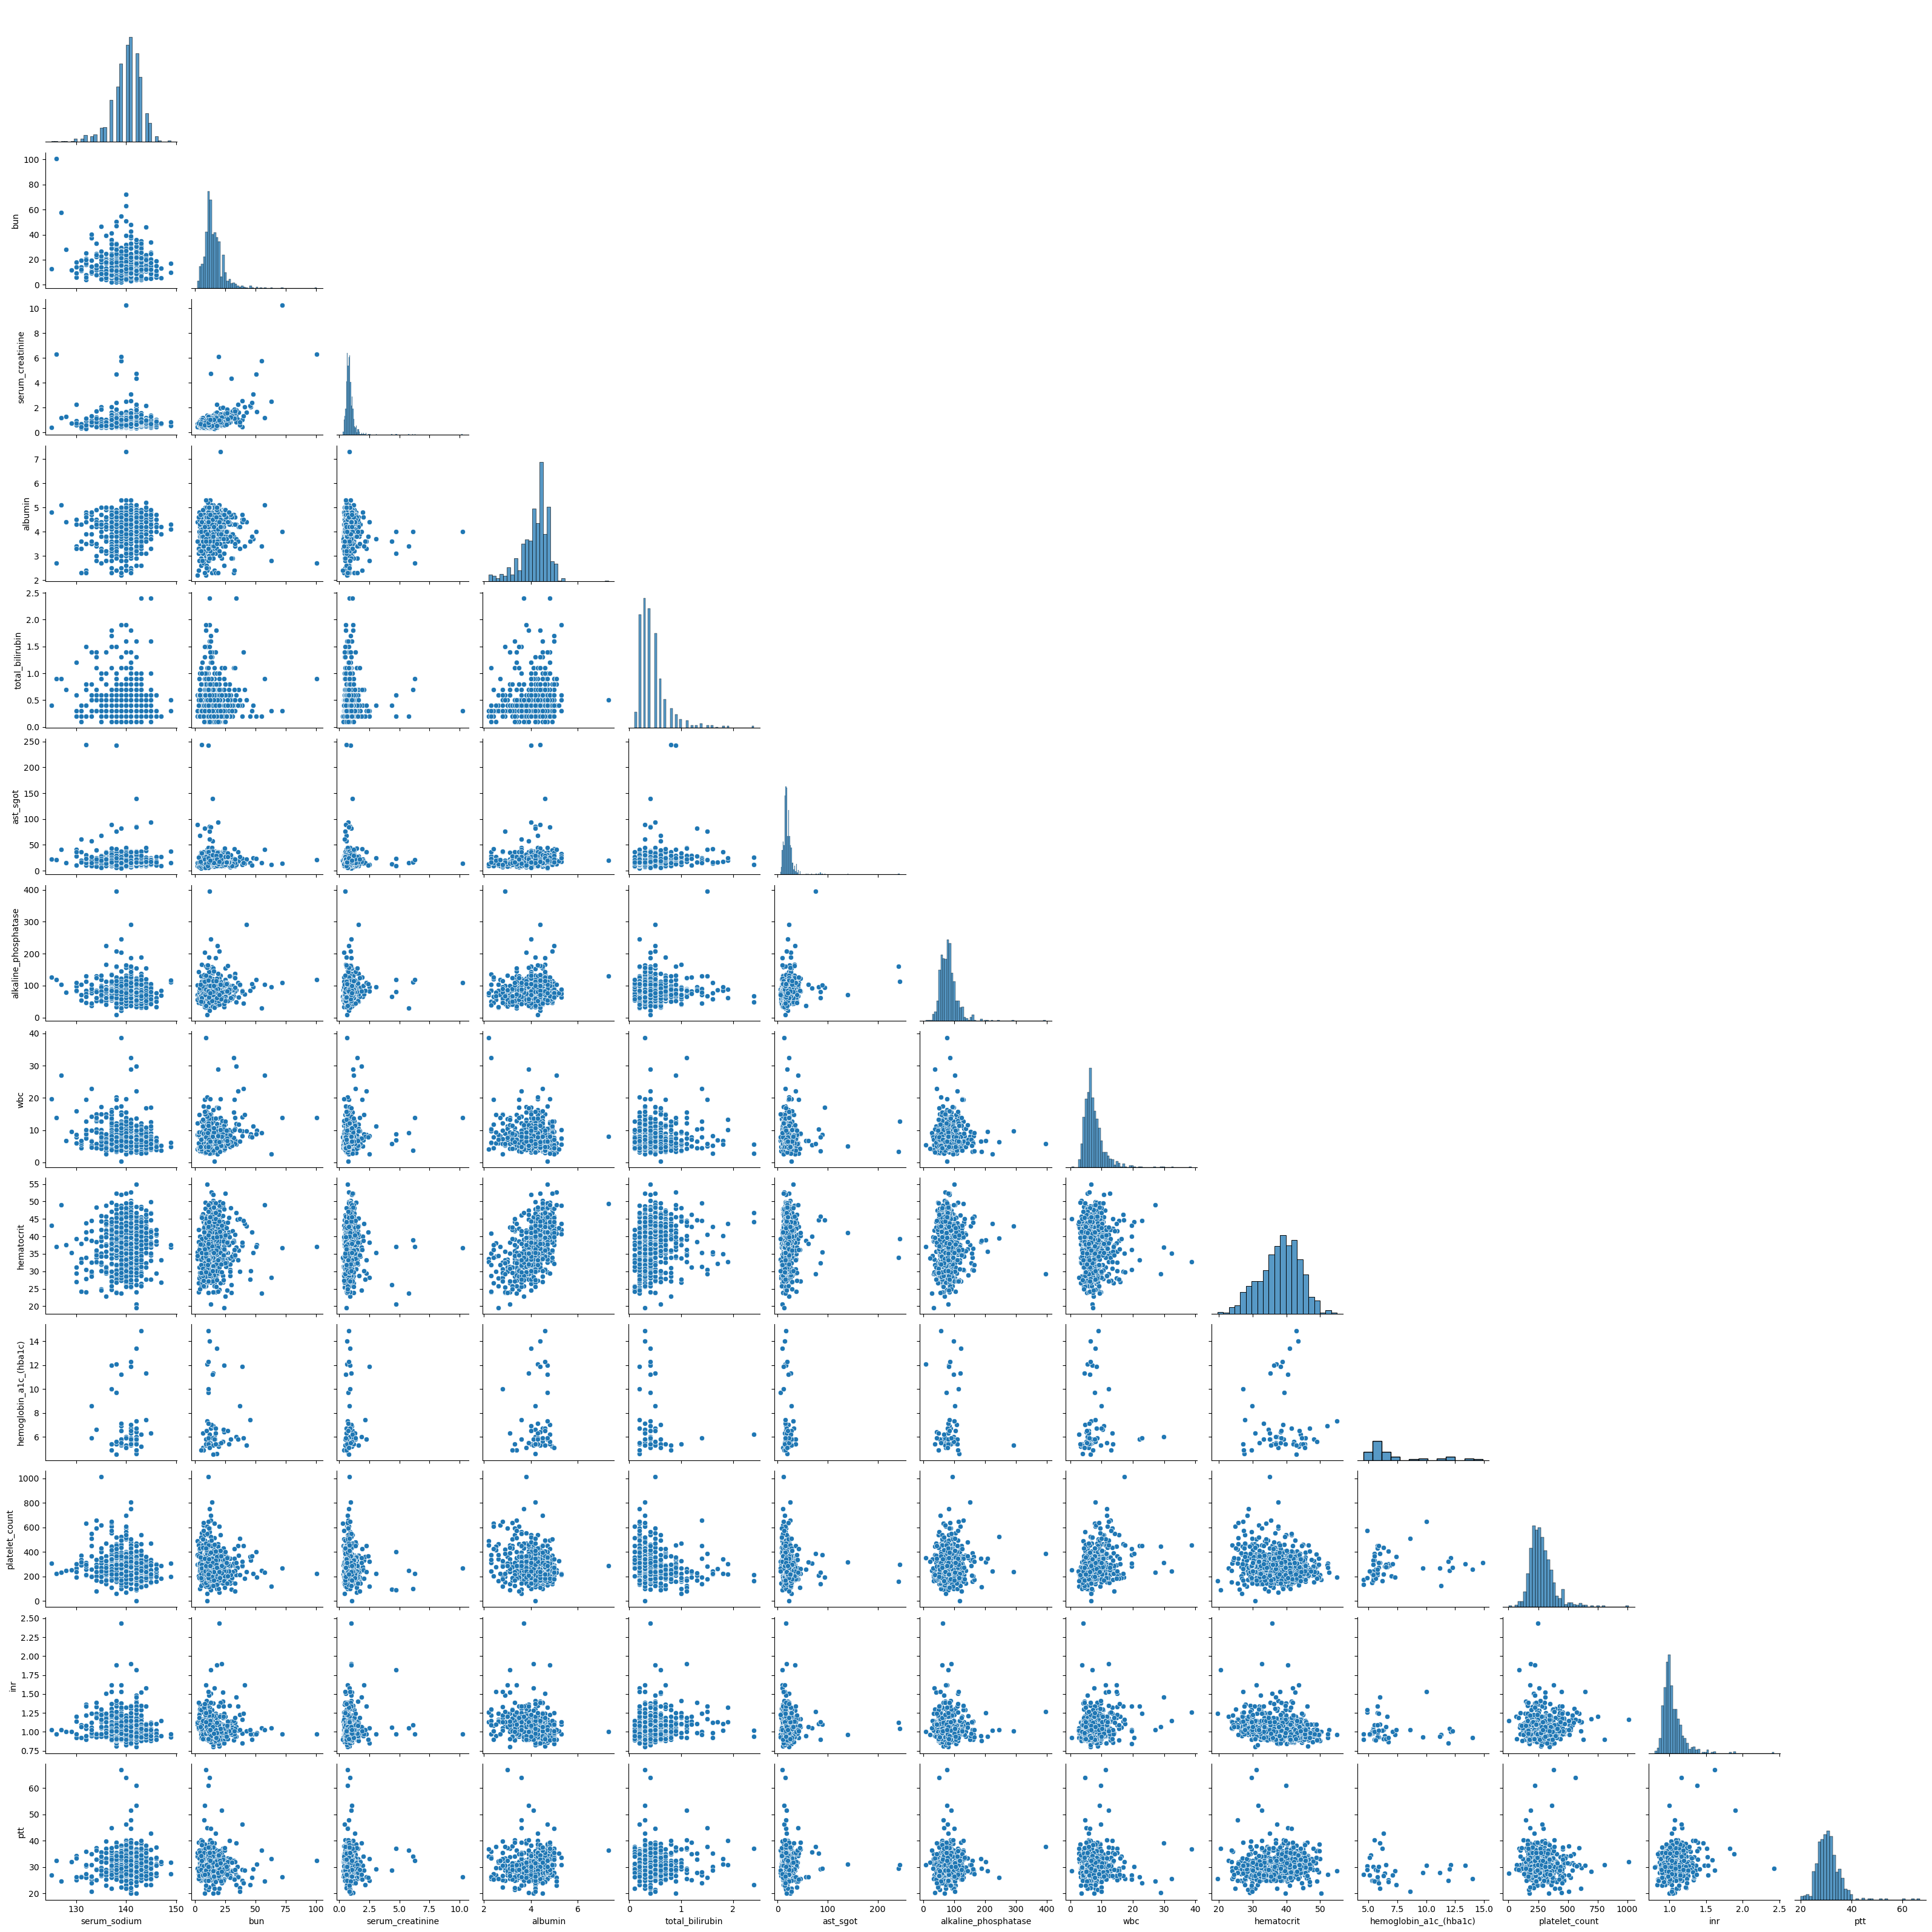

In [733]:
"""Plot relationships between lab values to identify multicollinearity"""

sns.pairplot(data = merged_colorectal[lab_tests],corner = True)


<AxesSubplot:>

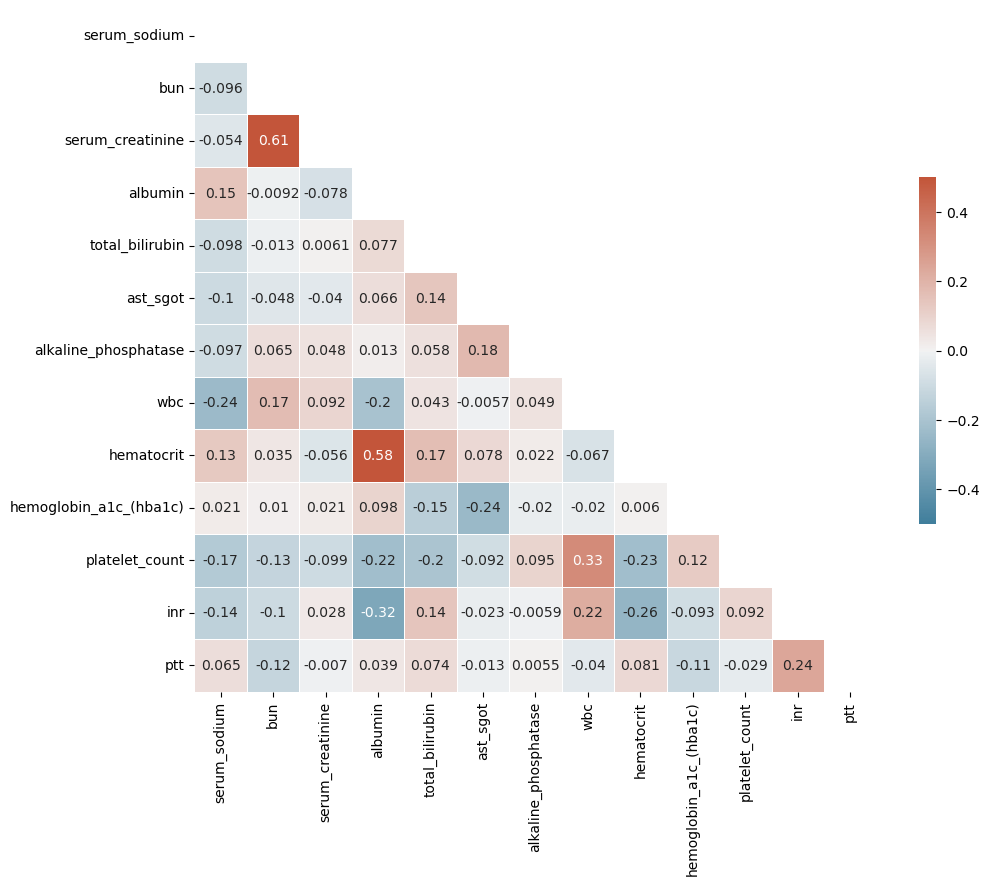

In [734]:
lab_test_corrs = merged_colorectal[lab_tests].corr(method = 'pearson')

#create a mask to zero out cells that evaluate to 1, or True
mask = np.triu(np.ones_like(lab_test_corrs, dtype = bool))

#create a colormap, blue for negative correlations, red for positive
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, axes = plt.subplots(figsize = (11,9))
sns.heatmap(lab_test_corrs,
            mask = mask, 
            vmax = 0.5,
            vmin = -0.5,
            center = 0, 
            square = True, 
            linewidths = 0.5, 
            cmap = cmap,
            annot = True,
            cbar_kws = {'shrink':0.5})

In [735]:
"""Complications that arise as a result of surgery are an important factor in determining length of stay. The 
following columns relate to complications. Remove columns which leak information, or do not relate to the original 
procedure."""

complications_cols = ['num_of_postop_superficial_incisional_ssi',
 'num_of_postop_deep_incisional_ssi',
 'num_of_postop_organ_space_ssi',
 'num_of_postop_wound_disruption',
 'num_of_postop_pneumonia',
 'num_of_postop_unplanned_intubation',
 'num_of_postop_pulmonary_embolism',
 'num_of_postop_on_ventilator_>_48_hours',
 'num_of_stroke_cerebral_vascular_acccident_(cva)',
 'num_of_cardiac_arrest_requiring_cpr',
 'num_of_myocardial_infarction',
 'num_of_postop_blood_transfusions',
 'total_blood_transfused_(in_units)',
 'num_of_postop_c__diff',
 'num_of_postop_sepsis',
 'num_of_postop_septic_shock',
 'num_of_postop_other_occurrences',
 'new_postop_covid_19_diagnosis']

In [736]:
merged_colorectal[complications_cols].isnull().sum()

num_of_postop_superficial_incisional_ssi             0
num_of_postop_deep_incisional_ssi                    0
num_of_postop_organ_space_ssi                        0
num_of_postop_wound_disruption                       0
num_of_postop_pneumonia                              0
num_of_postop_unplanned_intubation                   0
num_of_postop_pulmonary_embolism                     0
num_of_postop_on_ventilator_>_48_hours               0
num_of_stroke_cerebral_vascular_acccident_(cva)      0
num_of_cardiac_arrest_requiring_cpr                  0
num_of_myocardial_infarction                         0
num_of_postop_blood_transfusions                     0
total_blood_transfused_(in_units)                  731
num_of_postop_c__diff                                0
num_of_postop_sepsis                                 0
num_of_postop_septic_shock                           0
num_of_postop_other_occurrences                      0
new_postop_covid_19_diagnosis                      561
dtype: int

In [737]:
# Let's drop 'total_blood_transfused_(in_units)' and 'new_postop_covid_19_diagnosis' from the complications list

complications_cols = [col for col in complications_cols if col not in ['total_blood_transfused_(in_units)','new_postop_covid_19_diagnosis']]


In [738]:
complications_cols

['num_of_postop_superficial_incisional_ssi',
 'num_of_postop_deep_incisional_ssi',
 'num_of_postop_organ_space_ssi',
 'num_of_postop_wound_disruption',
 'num_of_postop_pneumonia',
 'num_of_postop_unplanned_intubation',
 'num_of_postop_pulmonary_embolism',
 'num_of_postop_on_ventilator_>_48_hours',
 'num_of_stroke_cerebral_vascular_acccident_(cva)',
 'num_of_cardiac_arrest_requiring_cpr',
 'num_of_myocardial_infarction',
 'num_of_postop_blood_transfusions',
 'num_of_postop_c__diff',
 'num_of_postop_sepsis',
 'num_of_postop_septic_shock',
 'num_of_postop_other_occurrences']

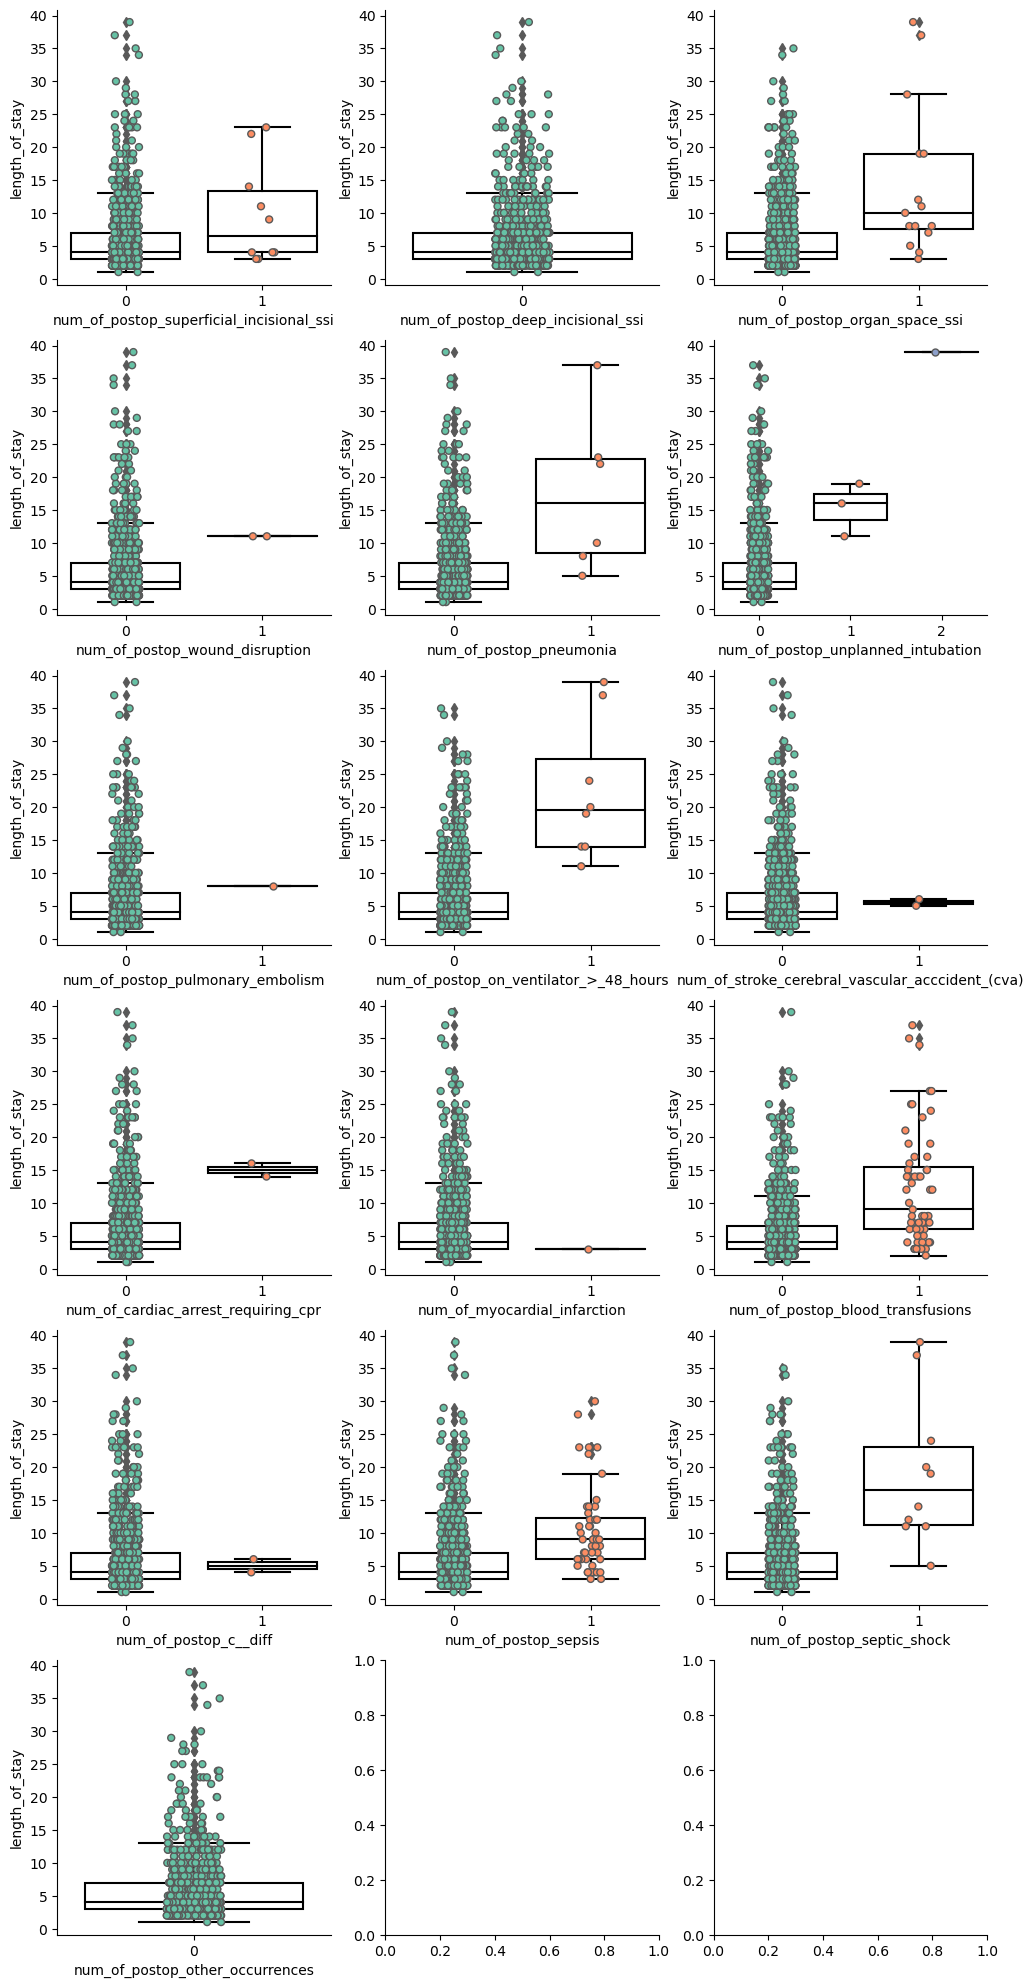

In [739]:
#Plot complications vs length of stay

fig, axs = plt.subplots(nrows=6, ncols=3,figsize = (12,25))
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
for col, ax in zip(complications_cols, axs.ravel()):
    sns.stripplot(x = col, y = 'length_of_stay', 
                  data = merged_colorectal,
                  ax = ax,
                  linewidth = 1,
                  jitter = 0.1,
                  palette = 'Set2')
    sns.boxplot(x = col, y = 'length_of_stay', 
                  data = merged_colorectal,
                  ax = ax,
                  palette = 'Set2',
                  **props)
    sns.despine()

In [740]:
"""Is there overlap between the 'num of postop sepsis' and 'num of postop septic shock columns?' """

pd.crosstab(index = merged_colorectal['num_of_postop_sepsis'], 
           columns = merged_colorectal['num_of_postop_septic_shock'], margins = True)

num_of_postop_septic_shock    0   1  All
num_of_postop_sepsis                    
0                           732  10  742
1                            48   0   48
All                         780  10  790

These are distinct columns.

In [741]:
"""Owing to the large class imbalance for most complications columns, we will sum complications and look at the
aggregate effect on length of stay. This can be justified by the fact that in all cases, based on the boxplots above,
having a complication increases length of stay."""

merged_colorectal['summed_complications'] = merged_colorectal[complications_cols].sum(axis = 1)

merged_colorectal['summed_complications'].value_counts().sort_index()

0    665
1     98
2     16
3      7
5      4
Name: summed_complications, dtype: int64

In [742]:
px.box(x = merged_colorectal.summed_complications,
            y = merged_colorectal.length_of_stay,
      points = 'all')

In [743]:
"""Bin complications into new ordinal column to look at aggregate effect of complications on length of stay."""

def bin_complications(num_complications):
    if num_complications == 0:
        Binned_complications = 'None'
    elif num_complications == 1:
        Binned_complications = 'One'
    elif num_complications == 2:
        Binned_complications = 'Two'
    elif num_complications >= 3:
        Binned_complications = 'Three_or_more'
    
    return Binned_complications


merged_colorectal['binned_complications'] = merged_colorectal['summed_complications'].apply(bin_complications)

In [744]:
merged_colorectal['binned_complications'].value_counts()

None             665
One               98
Two               16
Three_or_more     11
Name: binned_complications, dtype: int64

In [745]:
"""Boxplot of LOS as function of number of complications"""

fig = px.box(x = merged_colorectal['binned_complications'], 
            y = merged_colorectal['length_of_stay'],
      points = "all")
fig.update_xaxes(categoryorder='array', categoryarray= ['None','One','Two','Three_or_more'])
fig.show()

Length of stay increases monotonically with the number of complications The median length of stay appears to increase linearly bya factor of 3. 

In [746]:
"""Let's assess the extent of missing data in the columns of interest."""

model_cols = ['age',
              'race',
              'open_or_laparoscopic',
              'bmi',
              'case_acuity',
              'functionally_dpdt_or_ind',
              'duration_of_surgical_procedure_(in_minutes)']
model_cols.extend(lab_tests)
model_cols.extend(comorb_cols)
model_cols.extend(complications_cols)

<AxesSubplot:>

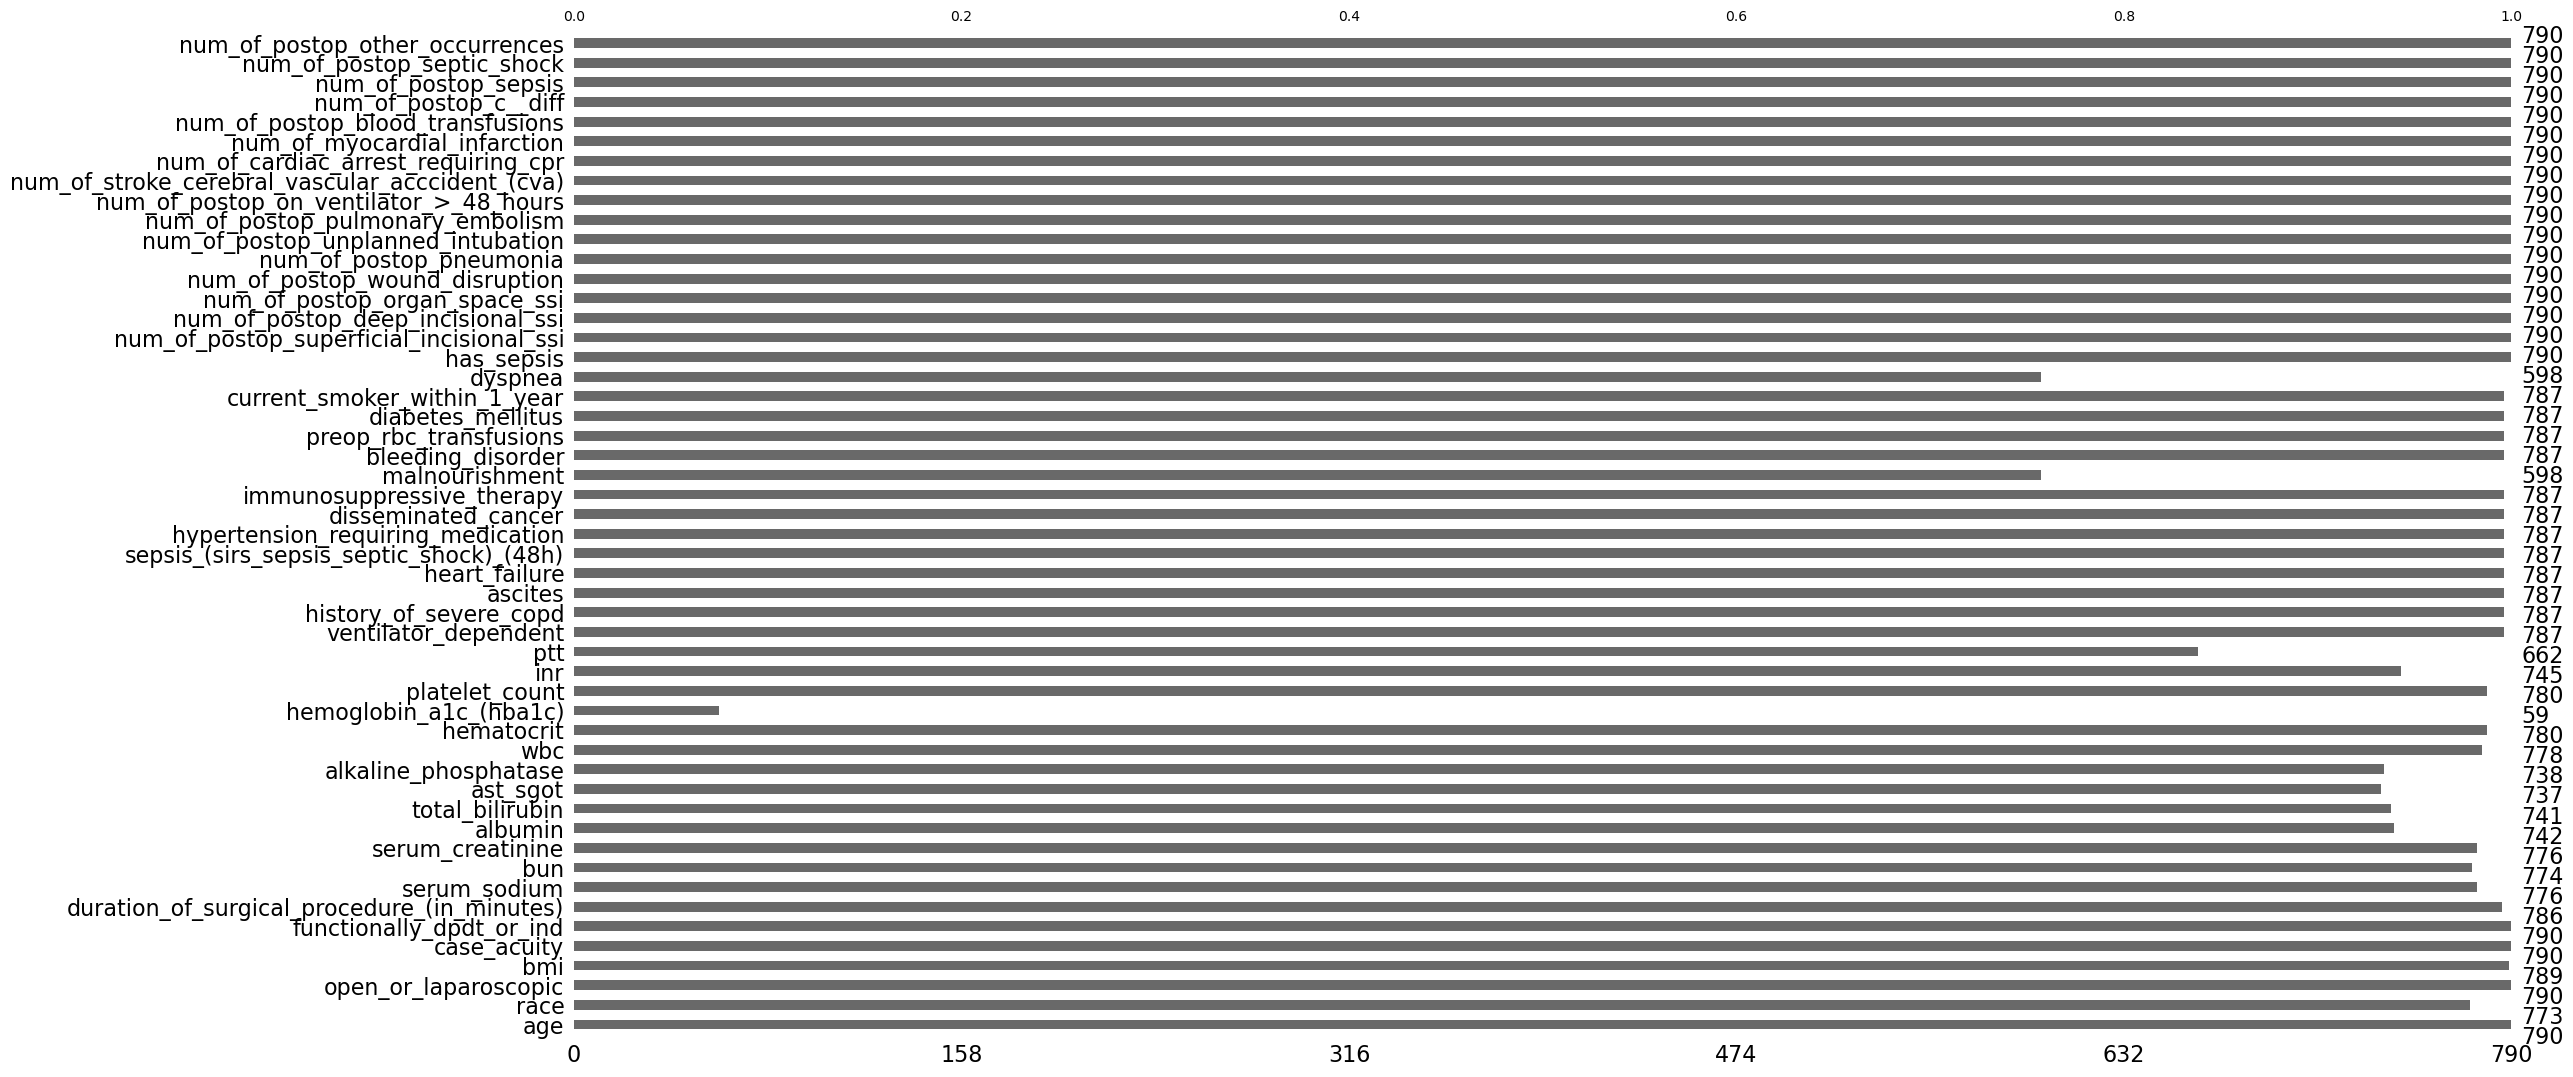

In [747]:
# Bar plot to display the amount of missing data in each column
msno.bar(merged_colorectal[model_cols])

The following columns are missing the vast majority of their data and may reduce the accuracy of the imputation:

'Hemoglobin A1c', 
'Total Blood Transfused', 
'New Postop COVID-19 Diagnosis',
'Preop COVID-19 Diagnosis'

<AxesSubplot:>

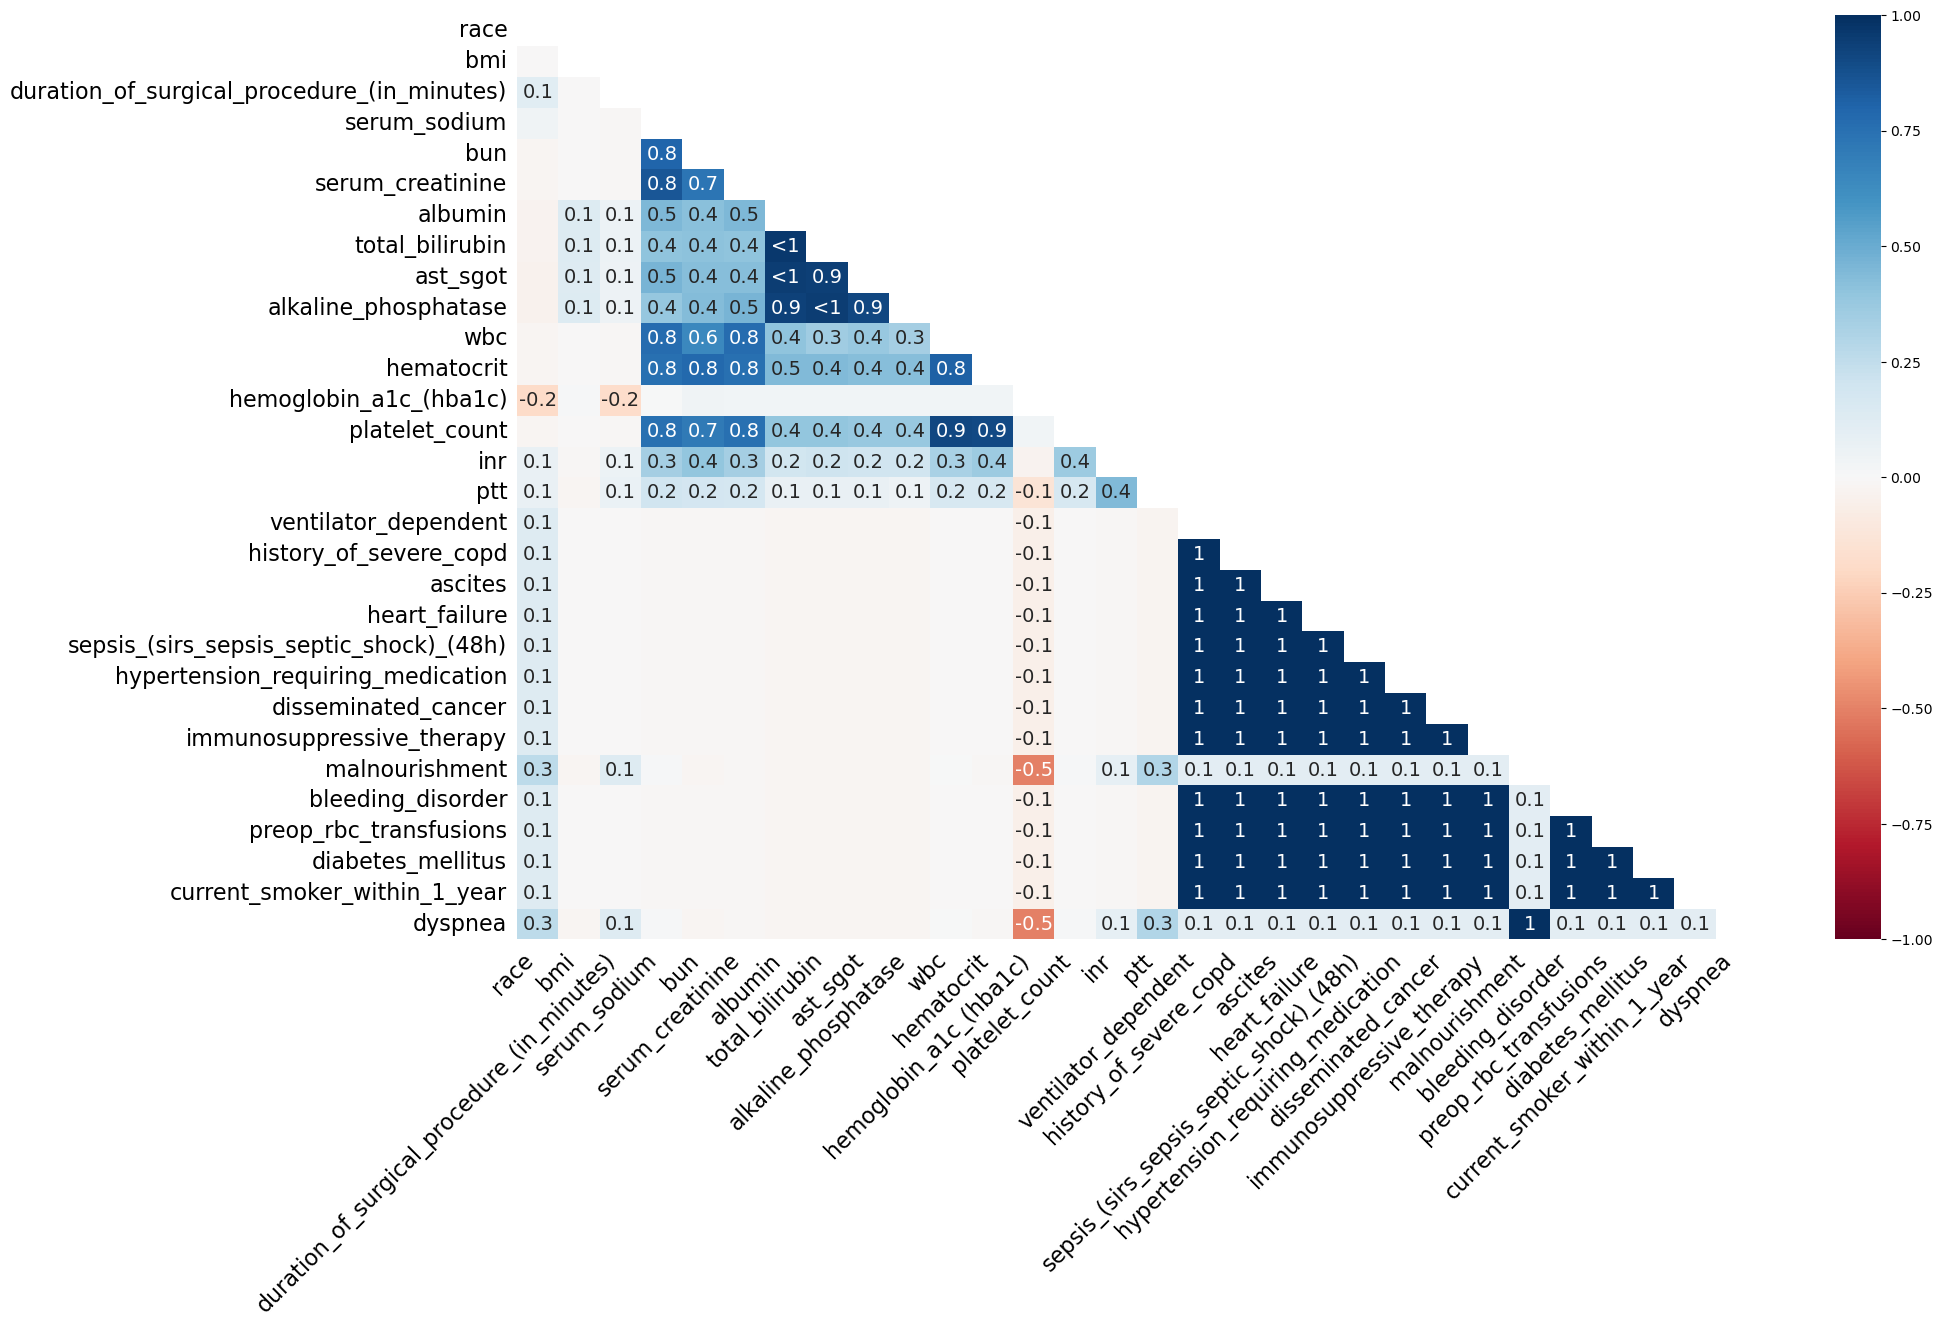

In [748]:
"""Heatmap to display pairwise correlations of present/missing data:
     1 indicates missing data in one column perfectly predicts the missing data in the other column of the pair
    -1 indicates missing data in one column does not at all predict the missing data in the other column of the pair"""

msno.heatmap(merged_colorectal[model_cols])

Where high positive correlations exist they are between missing lab values and missing comorbidity/complications values, and not between such values and demographic information,i.e race and age. This indicates that there is a group of patients for whom the record is simply incomplete, and not that there is some bias in the data collection process. 

In [749]:
%%capture

"""Now that data cleaning and EDA are complete, it is time to develop an explanatory model of length of stay. One 
approach is to build a generalized linear model for count data, which basically extends the logic of least squares
regression to non-normally distributed data. Typically Poisson and negative binomial regression are utilized for 
modeling count data. The key difference between these methods is that Poisson regression assumes that the distribution 
being modeled has variance equal to the mean, whereas negative binomial regression does not. Negative 
binomial regression allows for variance to vary as a quadratic function of the mean. """

In [750]:
"""Select columns for the model. Any variable that showed a correlation with LOS, or that is of interest, will be 
included."""

df_for_model = merged_colorectal[['age',
                                 'albumin',
                                 'inr',
                                 'hematocrit',
                                 'binned_complications',                                  
                                 'race',
                                 'platelet_count',
                                 'bun',
                                 'open_or_laparoscopic',
                                 'functionally_dpdt_or_ind',
                                 'length_of_stay',
                                 'has_sepsis',
                                 'immunosuppressive_therapy',
                                 'preop_rbc_transfusions',
                                 'heart_failure',
                                 'hypertension_requiring_medication',
                                 'disseminated_cancer',
                                 'bleeding_disorder',
                                 'diabetes_mellitus',
                                 'current_smoker_within_1_year',
                                 'ventilator_dependent',
                                 'charlson',
                                 'history_of_severe_copd',
                                 'wbc',
                                 'total_bilirubin',
                                 'serum_creatinine',
                                 'alkaline_phosphatase',
                                 'serum_sodium',
                                 'case_acuity']]


In [751]:
## Drop null values
df_for_model = df_for_model.dropna()

In [752]:
merged_colorectal[lab_tests].isnull().sum()

serum_sodium               14
bun                        16
serum_creatinine           14
albumin                    48
total_bilirubin            49
ast_sgot                   53
alkaline_phosphatase       52
wbc                        12
hematocrit                 10
hemoglobin_a1c_(hba1c)    731
platelet_count             10
inr                        45
ptt                       128
dtype: int64

In [753]:
df_for_model.columns.values

array(['age', 'albumin', 'inr', 'hematocrit', 'binned_complications',
       'race', 'platelet_count', 'bun', 'open_or_laparoscopic',
       'functionally_dpdt_or_ind', 'length_of_stay', 'has_sepsis',
       'immunosuppressive_therapy', 'preop_rbc_transfusions',
       'heart_failure', 'hypertension_requiring_medication',
       'disseminated_cancer', 'bleeding_disorder', 'diabetes_mellitus',
       'current_smoker_within_1_year', 'ventilator_dependent', 'charlson',
       'history_of_severe_copd', 'wbc', 'total_bilirubin',
       'serum_creatinine', 'alkaline_phosphatase', 'serum_sodium',
       'case_acuity'], dtype=object)

In [758]:
%%capture

"""Let's define a formula for the statsmodels GLM package. We will use the Patsy package to define a design matrix."""

# formula, in statsmodels format, using Patsy 
expr = """ length_of_stay ~ albumin + inr + C(race, Treatment(1)) + C(open_or_laparoscopic) + 
C(functionally_dpdt_or_ind) + C(heart_failure) + C(history_of_severe_copd) + C(has_sepsis)  + C(immunosuppressive_therapy)
 + C(hypertension_requiring_medication) + C(disseminated_cancer) + C(bleeding_disorder) + C(diabetes_mellitus, Treatment(1)) + 
 C(current_smoker_within_1_year) + hematocrit + platelet_count + age + wbc + alkaline_phosphatase + serum_creatinine + 
 serum_sodium + C(binned_complications) + C(case_acuity) """ 

In [759]:
# Fit and print the results of a glm model with the above model matrix configuration. We will first fit a Poisson
# regression model.

Poisson_reg = glm(expr,
            data = df_for_model, 
            family = sm.families.Poisson()).fit()

print(Poisson_reg.summary2())

                                    Results: Generalized linear model
Model:                            GLM                            AIC:                          3680.5252 
Link Function:                    Log                            BIC:                          -3027.3420
Dependent Variable:               length_of_stay                 Log-Likelihood:               -1809.3   
Date:                             2023-03-08 22:48               LL-Null:                      -2395.9   
No. Observations:                 686                            Deviance:                     1250.4    
Df Model:                         30                             Pearson chi2:                 1.48e+03  
Df Residuals:                     655                            Scale:                        1.0000    
Method:                           IRLS                                                                   
----------------------------------------------------------------------------------

In [760]:
# Fit and print the results of a glm model with the above model matrix configuration

NB2_reg = glm(expr,  
            data = df_for_model,
            # Fit data with a negative binomial regression, using the log link function, and dispersion
            # parameter of 0.36
            family = sm.families.NegativeBinomial(alpha = 0.3636)).fit()

print(NB2_reg.summary2())

                                    Results: Generalized linear model
Model:                            GLM                            AIC:                          3519.2476 
Link Function:                    Log                            BIC:                          -3941.0028
Dependent Variable:               length_of_stay                 Log-Likelihood:               -1728.6   
Date:                             2023-03-08 22:48               LL-Null:                      -1892.0   
No. Observations:                 686                            Deviance:                     336.72    
Df Model:                         30                             Pearson chi2:                 426.      
Df Residuals:                     655                            Scale:                        1.0000    
Method:                           IRLS                                                                   
----------------------------------------------------------------------------------

In [761]:
"""With linear regression, you can use R2 to quantify the amount of variance explained by the model. With other 
GLMs, though, there is no such metric.  """

1 - (NB2_reg.deviance/NB2_reg.null_deviance)

0.4925403027065197

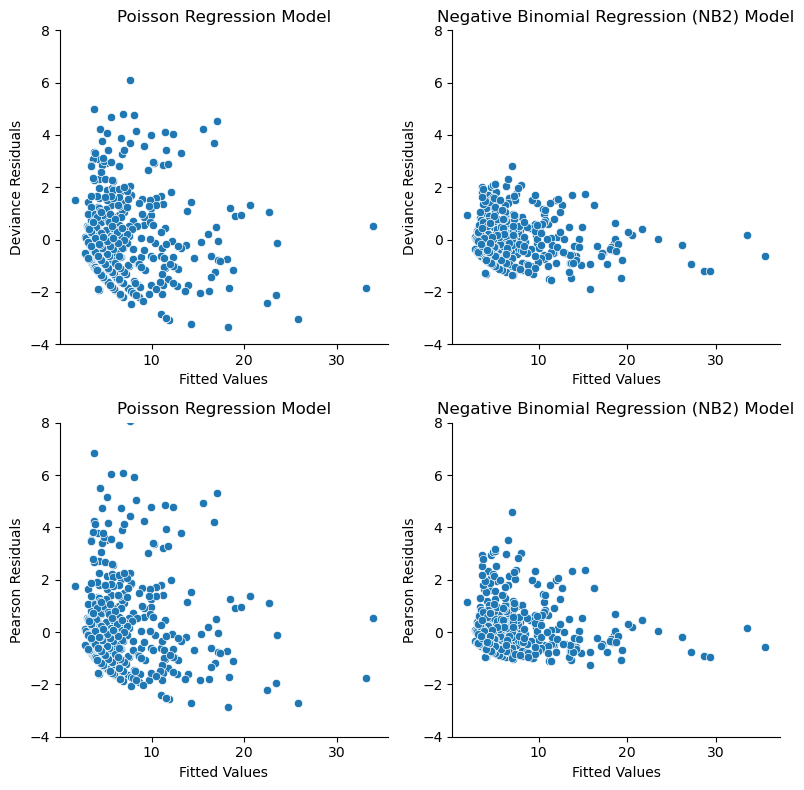

In [762]:
"""Diagnostic plots. 
To compare the performance and suitability of negative binomial and Poisson regression models for length of 
stay, let's look at two metrics:

1) Deviance is the difference in log likelihoods between the proposed and saturated models, and indicates
how good of a fit the proposed model is to the data. Plotting deviance residuals as a function of fitted values 
therefore reveals the contribution of each fitted value to the model deviance. 

2) A Pearson residual is the difference between predicted and observed value, standardized by the standard deviation
of the observed values. The presence of a large number of values beyond +-2 standard deviations therefore suggests
poor model fit."""


fig,axes = plt.subplots(2,2,figsize = (8,8))
sns.scatterplot(x = Poisson_reg.fittedvalues,y = Poisson_reg.resid_deviance,ax = axes[0][0])
axes[0][0].set_xlabel('Fitted Values')
axes[0][0].set_ylabel('Deviance Residuals')
axes[0][0].set_title('Poisson Regression Model')
axes[0][0].set_ylim(bottom = -4, top = 8)
sns.scatterplot(x = NB2_reg.fittedvalues,y = NB2_reg.resid_deviance, ax = axes[0][1])
axes[0][1].set_xlabel('Fitted Values')
axes[0][1].set_ylabel('Deviance Residuals')
axes[0][1].set_title('Negative Binomial Regression (NB2) Model')
axes[0][1].set_ylim(bottom = -4, top = 8)
sns.scatterplot(x = Poisson_reg.fittedvalues,y = Poisson_reg.resid_pearson,ax = axes[1][0])
axes[1][0].set_xlabel('Fitted Values')
axes[1][0].set_ylabel('Pearson Residuals')
axes[1][0].set_title('Poisson Regression Model')
axes[1][0].set_ylim(bottom = -4, top = 8)
sns.scatterplot(x = NB2_reg.fittedvalues,y = NB2_reg.resid_pearson, ax = axes[1][1])
axes[1][1].set_xlabel('Fitted Values')
axes[1][1].set_ylabel('Pearson Residuals')
axes[1][1].set_title('Negative Binomial Regression (NB2) Model')
axes[1][1].set_ylim(bottom = -4, top = 8)

sns.despine()

fig.tight_layout()

plt.show()

The negative binomial regression model leads to smaller deviance and Pearson residuals than the Poisson regression model, indicating a better fit for the data.

In [763]:
"""Perform a chi-square test comparing the the NB2 model with a dispersion parameter, and the Poisson model with mean
equal to the variance. The null hypothesis is that the value of the dispersion parameter should be 1, in other words,
that the negative binomial regression is not a better fit than Poisson regression."""

def likelihood_ratio_test(log_likelihood_null, log_likelihood_alt, df):

    LR_statistic = -2 * (log_likelihood_null - log_likelihood_alt)

    p_val = scipy.stats.chi2.sf(LR_statistic, df)

    print(f"p-value = {p_val}")
    return(LR_statistic, p_val)

In [764]:
likelihood_ratio_test(Poisson_reg.llf, NB2_reg.llf, df = 1)

p-value = 5.9500241428284455e-37


(161.27758224575336, 5.9500241428284455e-37)

Given the p-value, we should reject the null hypothesis that negative binomial regression, with its additonal dispersion parameter, does not provide a better fit to the data than does Poisson regression.


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



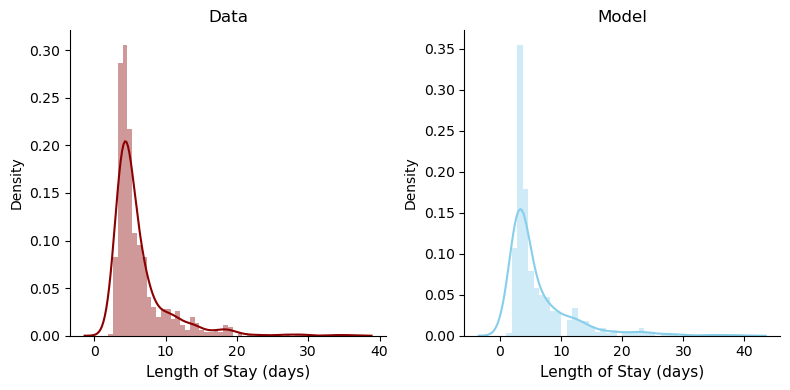

In [765]:
# plot distributions
fig, axes = plt.subplots(1,2, 
                         squeeze = False, 
                         figsize = (8,4))
sns.distplot(NB2_reg.predict(), ax = axes[0][0], color = 'darkred')
axes[0][1].set_title('Model')
sns.distplot(df_for_model['length_of_stay'], ax = axes[0][1], color = 'skyblue')
axes[0][0].set_xlabel('Length of Stay (days)',fontsize = 11)
axes[0][1].set_xlabel('Length of Stay (days)', fontsize = 11)
axes[0][0].set_title('Data')
sns.despine()
plt.tight_layout()
plt.show()


The negative binomial regression models appears to recapitulate the main features of the data, but underestimates
the density of the tail.

In [811]:
# Define function to output plot of the model coefficients

def coefplot(results, coef_labels = False, vars_to_drop = False):
    '''
    Takes in results of regression model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df = coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])
    if coef_labels:
        coef_df = coef_df.rename(index = coef_labels)
    if vars_to_drop:
        coef_df = coef_df.drop(vars_to_drop, axis = 0)
    
    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['Intercept'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x  ='variables', y = 'coef', kind = 'bar',
                 ax = ax, color='none', fontsize = 12, 
                 ecolor = 'steelblue',capsize = 0,
                 yerr = 'errors', legend = False)
    
    # Set title & labels
    plt.title('Contribution of Model Variables to Length of Stay',fontsize=15)
    ax.set_ylabel('Change in LOS (log(LOS))',fontsize=12)
    ax.set_xlabel('',fontsize = 22)
    
    xlabels = [i for i in coef_df.index]
    ax.set_xticklabels(labels = xlabels, rotation=45, ha='right')
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='black')
    
    # Line to define zero on the y-axis
    ax.axhline(y = 0, linestyle = '--', color = 'red', linewidth = 1)
    
    
    return plt.show()


In [769]:
new_vars = {'C(functionally_dpdt_or_ind)[T.Independent]':'Functionally dependent',
                             'C(race, Treatment(1))[T.Black or African American]':'Black/African American',
                             'C(race, Treatment(1))[T.White]':'Caucasian',
                             'C(binned_complications)[T.One]': '1 complication',
                             'C(binned_complications)[T.Two]':'2 complications',
                             'C(binned_complications)[T.Three_or_more]':'3 complications',
                             'C(open_or_laparoscopic)[T.Open]':'Open surgery',
                             'C(heart_Failure)[T.Yes]':'Heart failure',
                             'C(has_sepsis)[T.Yes]':'Sepsis',
                             'C(history_of_severe_copd)[T.Yes]':'History of COPD',
                             'C(race, Treatment(1))[T.American Indian or Alaska Native]':'American Indian or Alaskan Native',
                             'C(race, Treatment(1))[T.Hispanic]':'Hispanic',
                             'C(diabetes_mellitus, Treatment(1))[T.Non-Insulin]':'Diabetes(Non-Insulin)',
                             'C(diabetes_mellitus, Treatment(1))[T.Insulin]':'Diabetes(Insulin)',
                             'C(bleeding_disorder)[T.Yes]':"Bleeding disorder",
                             'C(current_smoker_within_1_year)[T.Yes]':'Smoker',
                             'C(hypertension_requiring_medication)[T.Yes]':'Hypertension',
                             'C(immunosuppressive_therapy)[T.Yes]':'Immuno. Therapy',
                             'C(disseminated_cancer)[T.Yes]':'Dissem. cancer',
                             'C(heart_failure)[T.Yes]':'Heart failure',
                             'albumin':'Albumin',
                             'serum_creatinine':'Serum creatinine',
                             'serum_sodium':'Serum sodium',
                             'hematocrit':'Hematocrit',
                             'wbc':'WBC',
                             'alkaline_phosphatase':'Alkaline phosphatase',
                             'platelet_count':'Platelet count',
                             'inr':'INR',
                             'age':'Age',
                             'C(case_acuity)[T.Urgent/Emergent]':'Urgent/emergent'}

/var/folders/v9/483tmlvj28ldt2s2wvphywvxd4j0g_/T/ipykernel_77189/2886564470.py:72: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



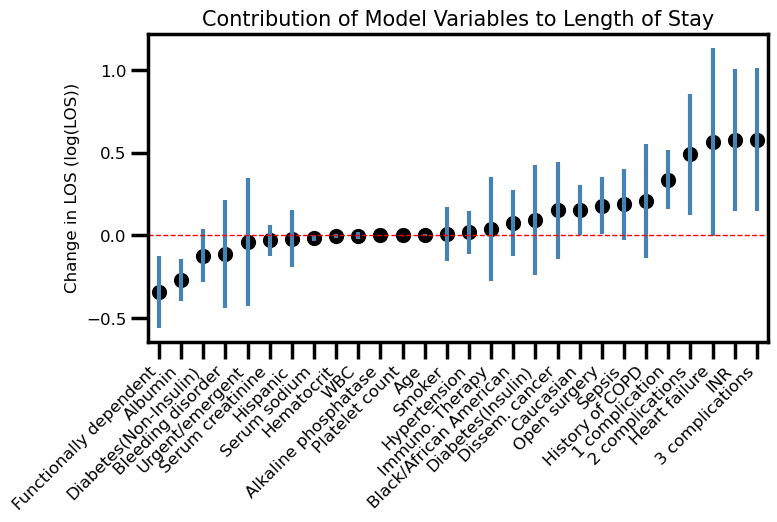

In [812]:
coefplot(results = NB2_reg, coef_labels = new_vars, 
         vars_to_drop = ['American Indian or Alaskan Native',
                        'C(race, Treatment(1))[T.Unknown/Not Reported]']
        )

We will now quantify the predictive accuracy of our negative binomial regression model using K-fold cross-validation to assess its ability to predict length of stay given unseen data.

We will need to remove all variables that carry post-operative information. This should just be the 'binned_complications' column. 


In [771]:
# formula, in statsmodels format, using Patsy 
expr = """ length_of_stay ~ albumin + inr + C(race, Treatment(1)) + C(open_or_laparoscopic) + 
C(functionally_dpdt_or_ind) + C(heart_failure) + C(history_of_severe_copd) + C(has_sepsis)  + C(immunosuppressive_therapy)
 + C(hypertension_requiring_medication) + C(disseminated_cancer) + C(bleeding_disorder) + C(diabetes_mellitus, Treatment(1)) + 
 C(current_smoker_within_1_year) + hematocrit + platelet_count + age + wbc + alkaline_phosphatase + serum_creatinine + 
 serum_sodium + C(case_acuity)""" 

In [772]:
# Fit and print the results of a glm model with the above model matrix configuration

NB2_reg_pred = glm(expr,  
            data = df_for_model,
            # Fit data with a negative binomial regression, using the log link function, and dispersion
            # parameter of 0.36
            family = sm.families.NegativeBinomial(alpha = 0.3636)).fit()

print(NB2_reg_pred.summary2())

                                    Results: Generalized linear model
Model:                            GLM                            AIC:                          3534.7312 
Link Function:                    Log                            BIC:                          -3939.1118
Dependent Variable:               length_of_stay                 Log-Likelihood:               -1739.4   
Date:                             2023-03-08 22:50               LL-Null:                      -1892.0   
No. Observations:                 686                            Deviance:                     358.21    
Df Model:                         27                             Pearson chi2:                 466.      
Df Residuals:                     658                            Scale:                        1.0000    
Method:                           IRLS                                                                   
----------------------------------------------------------------------------------

In [773]:
"""Function to calculate rot-mean-squared error."""

def RMSE(array1, array2):
    """Calculate RMSE """
    squared_error = np.sum(((array1 - array2) **2))
    RMSE = np.sqrt(squared_error / len(array1))
    return RMSE

In [774]:
# Reset the index

df_for_model = df_for_model.reset_index()

In [775]:
"""Perform k-fold cross-validation on both the Poisson and negative binomial regression models. This will allow
us to directly assess the accuracy of each model when making predictions of length of stay based on unseen data."""


# Create kfold column and intiate it with a dummy value
df_for_model["kfold"] = -1

# create k-fold instance with 10 splits on shuffled dataset
kf = KFold(n_splits = 10, shuffle = True)
# for loop to create the k-folds
for fold, (train_indicies, test_indicies) in enumerate(kf.split(X = df_for_model)):
    df_for_model.loc[test_indicies, "kfold"] = fold


NB2_summaries = {}
NB2_test_actual = []
NB2_test_predictions = []
NB2_training_predictions = []
NB2_test_RMSEs = []
NB2_train_RMSEs = []

Poisson_summaries = {}
Poisson_test_predictions = []
Poisson_training_predictions = []
Poisson_test_RMSEs = []
Poisson_train_RMSEs = []

for i in range(5):
    y_train, x_train = dmatrices(expr, 
                                df_for_model[df_for_model['kfold'] != i],
                                return_type = 'dataframe')
    y_test, x_test = dmatrices(expr, 
                               df_for_model[df_for_model['kfold'] == i], 
                               return_type = 'dataframe')
        
    x_train, x_test = x_train.align(x_test, join = 'outer', axis = 1, fill_value = 0)
    
    # Fit negative binomial regression model
    NB2_model = sm.GLM(y_train, 
                       x_train, 
                       family = sm.families.NegativeBinomial(alpha = 0.36)).fit() 
    NB2_summaries[i] = NB2_model.summary2()
    
    #Generate predictions on test set
    NB2_test_predicted = NB2_model.get_prediction(x_test)
    NB2_test_predictions.append(NB2_test_predicted.summary_frame()['mean'])
    
    #Generate predictions on train set
    NB2_training_predicted = NB2_model.get_prediction(x_train)
    NB2_training_predictions.append(NB2_training_predicted)
    
    #Calculate RMSE for test fold
    NB2_test_RMSE = RMSE(NB2_test_predicted.summary_frame()['mean'],
                         y_test['length_of_stay'])
    NB2_test_RMSEs.append(NB2_test_RMSE)    

    #Calculate RMSE for training folds
    NB2_train_RMSE = RMSE(NB2_training_predicted.summary_frame()['mean'],
                          y_train['length_of_stay'])
    NB2_train_RMSEs.append(NB2_train_RMSE)
    
    # Append predictions actual LOS values
    NB2_test_actual.append(y_test)
    
    
    
    # Fit Poisson regression model
    Poisson_model = sm.GLM(y_train, 
                           x_train, 
                           family = sm.families.Poisson()).fit()
     
    Poisson_summaries[i] = Poisson_model.summary2()
    
    #Generate predictions on test folds
    Poisson_test_predicted = Poisson_model.get_prediction(x_test)
    Poisson_test_predictions.append(Poisson_test_predicted)
   
    #Generate predictions on train folds
    Poisson_training_predicted = Poisson_model.get_prediction(x_train)
    Poisson_training_predictions.append(Poisson_training_predicted)
    
    #Calculate RMSE for test fold
    Poisson_test_RMSE = RMSE(Poisson_test_predicted.summary_frame()['mean'],
                             y_test['length_of_stay'])
    Poisson_test_RMSEs.append(Poisson_test_RMSE)    
    
    #Calculate RMSE for training folds
    Poisson_train_RMSE = RMSE(Poisson_training_predicted.summary_frame()['mean'],
                              y_train['length_of_stay'])
    Poisson_train_RMSEs.append(Poisson_train_RMSE)


In [776]:
"""Assemble dataframe of predictions and actual LOS values for plotting"""

NB2_preds = reduce(lambda x,y: pd.concat([x,y]),NB2_test_predictions)
NB2_actual = reduce(lambda x,y: pd.concat([x,y]),NB2_test_actual)
NB2_preds_actual = pd.concat([NB2_preds, NB2_actual], axis = 1)
NB2_preds_actual

mean  length_of_stay
2    6.174068             8.0
21   4.146199             3.0
36   7.831458             8.0
48   3.740991             3.0
52   6.317113             5.0
..        ...             ...
643  5.127966             6.0
652  4.886693             4.0
654  5.037812             3.0
662  4.497899             3.0
679  4.142282             2.0

[345 rows x 2 columns]

In [777]:
"""Assemble LOS from data, predicted LOS values, and RMSE into a dataframe"""

NB2_preds_actual['RMSE'] = 1
for i in NB2_preds_actual['length_of_stay'].unique():
    NB2_preds_actual['RMSE'] = np.where(NB2_preds_actual['length_of_stay'] == i,
                                        RMSE(NB2_preds_actual[NB2_preds_actual['length_of_stay'] ==i]['length_of_stay'],
                                             NB2_preds_actual[NB2_preds_actual['length_of_stay'] ==i]['mean']),
                                        NB2_preds_actual['RMSE'])

In [778]:
NB2_preds_actual.head()

mean  length_of_stay      RMSE
2   6.174068             8.0  3.321103
21  4.146199             3.0  2.451948
36  7.831458             8.0  3.321103
48  3.740991             3.0  2.451948
52  6.317113             5.0  1.336224

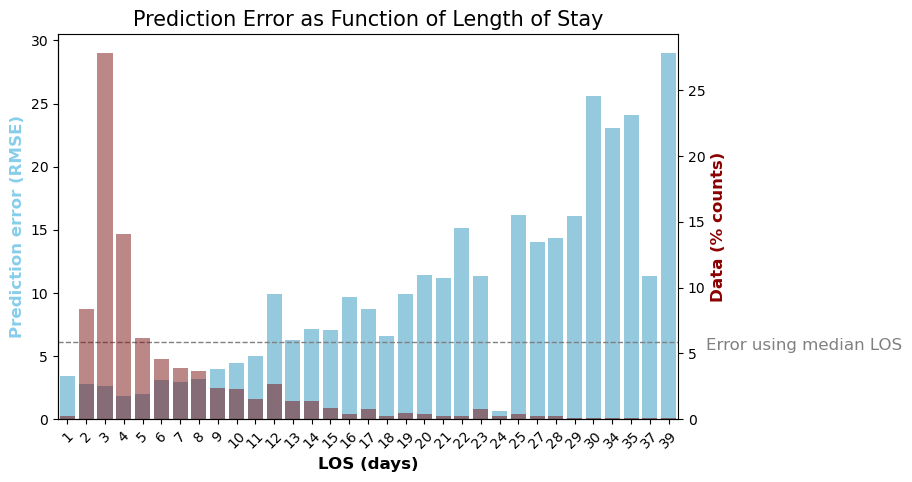

In [794]:
"""Plot LOS from data with the average prediction error overlaid."""

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,5))
sns.barplot(x = NB2_preds_actual['length_of_stay'].astype(int),
           y = NB2_preds_actual['RMSE'],
           color = 'skyblue')
axs.set_xlabel('LOS (days)',fontdict = {'fontsize': 12}, fontweight = 'bold')
axs.set_ylabel('Prediction error (RMSE)',fontdict = {'fontsize': 12}, fontweight = 'bold', color = 'skyblue')
axs.axhline(y = 6.1, linestyle = '--', color = 'grey', linewidth = 1)
sns.despine()
axs.set_title('Prediction Error as Function of Length of Stay',
          fontdict = {'fontsize':15})
axs.text(x = 34, y = 5.5, s = 'Error using median LOS', color = 'grey', fontdict = {'fontsize': 12})
plt.xticks(rotation = 45)

#Create overlapping set of axes with shared x axis
ax2 = axs.twinx()

#plot counts of data LOS
sns.barplot(x = NB2_preds_actual['length_of_stay'].astype(int),
            y = NB2_preds_actual['length_of_stay'].astype(int),
            #plot normalized count for each bin (number of days), rather than mean
            estimator = lambda x: len(x) / len(merged_colorectal) * 100,
            ax = ax2,
            alpha = 0.5,
            color = 'darkred')
ax2.set_ylabel('Data (% counts)', fontweight = 'bold',fontdict = {'fontsize': 12}, color = 'darkred')

plt.show();

In [780]:
"""Calculate the mean test and training RMSEs for both models"""

#Negative binomial regression model 
NB2_mean_test_RMSE = (np.sum(NB2_test_RMSEs) / len(NB2_test_RMSEs))
NB2_mean_train_RMSE = (np.sum(NB2_train_RMSEs)/len(NB2_train_RMSEs))

print(f" The average RMSE for NB2 model predictions on training folds  = {NB2_mean_train_RMSE}")
print(f" The average RMSE for NB2 model predictions on test folds = {NB2_mean_test_RMSE}")


#Poisson regression model
Poisson_mean_test_RMSE = (np.sum(Poisson_test_RMSEs) / len(Poisson_test_RMSEs))
Poisson_mean_train_RMSE = (np.sum(Poisson_train_RMSEs) / len(Poisson_train_RMSEs))

print(f" The average RMSE for Poisson model predictions on training folds  = {Poisson_mean_train_RMSE}")
print(f" The average RMSE for Poisson model predictions on test folds = {Poisson_mean_test_RMSE}")


 The average RMSE for NB2 model predictions on training folds  = 4.419560006316545
 The average RMSE for NB2 model predictions on test folds = 4.636863206498893
 The average RMSE for Poisson model predictions on training folds  = 4.267903959040951
 The average RMSE for Poisson model predictions on test folds = 4.578583853046808


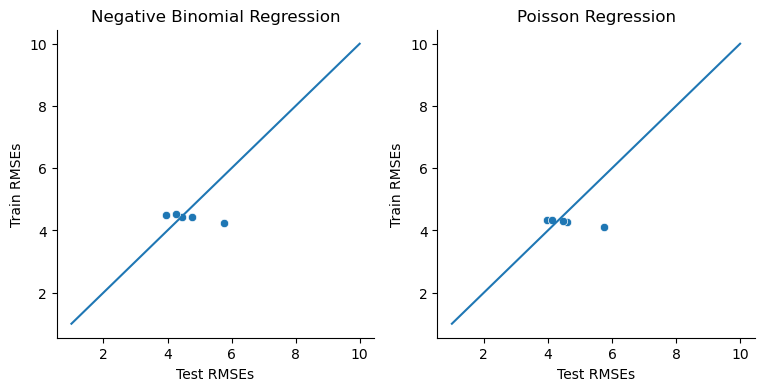

In [781]:
"""Let's plot the train and test RMSEs against one another. This plot will tell us about the variance among both
sets of RMSEs, and allow us to diagnose systematic under- or overfitting."""

fig, axes = plt.subplots(1,2, figsize = (9,4), squeeze = False)
sns.scatterplot(x = NB2_test_RMSEs, y = NB2_train_RMSEs, ax = axes[0][0])
x = np.linspace(1,10,num = 300)
axes[0][0].plot(x,x)
axes[0][0].set_xlabel("Test RMSEs")
axes[0][0].set_ylabel("Train RMSEs")
axes[0][0].set_title('Negative Binomial Regression')
sns.scatterplot(x = Poisson_test_RMSEs, y = Poisson_train_RMSEs, ax = axes[0][1])
x = np.linspace(1,10,num = 300)
axes[0][1].plot(x,x)
axes[0][1].set_xlabel("Test RMSEs")
axes[0][1].set_ylabel("Train RMSEs")
axes[0][1].set_title('Poisson Regression')
sns.despine()

plt.show()

Overfitting is not a problem for either model, as test_rmse values are distributed evenly across the unity line.

In [782]:
"""Does the model perform consistently across the range of LOS values? The distribution of LOS is heavily skewed,
with relatively few counts in each count bin of the tail compared to count bins around the median. This
asymmetry may lead to comparatively poorer predictions for larger LOS values in the training and test sets."""

# Separate the actual values of the last test fold into below and above-median values
below_median_data = y_test[y_test['length_of_stay'] < merged_colorectal['length_of_stay'].median()]
above_median_data = y_test[y_test['length_of_stay'] > merged_colorectal['length_of_stay'].median()]


NB2_RMSE_below_median = RMSE(NB2_test_predicted.summary_frame().loc[below_median_data.index]['mean'],
                         below_median_data['length_of_stay'])

NB2_RMSE_above_median = RMSE(above_median_data['length_of_stay'], 
                         NB2_test_predicted.summary_frame().loc[above_median_data.index]['mean'])


print(f" RMSE for below-median LOS with NB2 regression = {NB2_RMSE_below_median}")
print(f" RMSE for above-median LOS with NB2 regression = {NB2_RMSE_above_median}")

# Mean standard error for below and above median predictions from Poisson model
Poisson_below_median_SE = np.mean(Poisson_test_predicted.summary_frame().loc[below_median_data.index]['mean_se'])
Poisson_above_median_SE = np.mean(Poisson_test_predicted.summary_frame().loc[above_median_data.index]['mean_se'])

# Mean standard error for below and above median predictions from NB2 model
NB2_below_median_SE = np.mean(NB2_test_predicted.summary_frame().loc[below_median_data.index]['mean_se'])
NB2_above_median_SE = np.mean(NB2_test_predicted.summary_frame().loc[above_median_data.index]['mean_se'])

print(f" Average standard error of prediction for below-median LOS with Poisson regression = {Poisson_below_median_SE}")
print(f" Average standard error of prediction for above-median LOS with Poisson regression = {Poisson_above_median_SE}")

print(f" Average standard error of prediction for below-median LOS with NB2 regression = {NB2_below_median_SE}")
print(f" Average standard error of prediction for above-median LOS with NB2 regression = {NB2_above_median_SE}")

 RMSE for below-median LOS with NB2 regression = 3.2789250089833106
 RMSE for above-median LOS with NB2 regression = 5.790314939110692
 Average standard error of prediction for below-median LOS with Poisson regression = 0.32199453655443033
 Average standard error of prediction for above-median LOS with Poisson regression = 0.9591525138650021
 Average standard error of prediction for below-median LOS with NB2 regression = 0.5957915233844613
 Average standard error of prediction for above-median LOS with NB2 regression = 2.072487772208799


The model performs significantly more poorly when predicting length of stay values greater than the median, as indicated by both the larger RMSE and standard error for above-median predictions.

In [783]:
"""Does the model provide better predictions than the median value of LOS?"""
Median_LOS = merged_colorectal['length_of_stay'].median()

RMSE_using_median = RMSE(np.ones_like(y_train['length_of_stay']) * Median_LOS,
                         y_train['length_of_stay'])

print(f" RMSE using median  = {RMSE_using_median}")



 RMSE using median  = 6.036893595117296


The negative binomial regression model provides substantially more accurate predictions of length of stay than does the median LOS, with a difference in MAE of >1.5 days.

In [784]:
# formula, in statsmodels format, using Patsy 
expr = """ length_of_stay ~ albumin + inr + C(race, Treatment(1)) + C(open_or_laparoscopic) + 
C(functionally_dpdt_or_ind) + C(heart_failure) + C(history_of_severe_copd) + C(has_sepsis)  + C(immunosuppressive_therapy)
 + C(disseminated_cancer) + C(bleeding_disorder) + C(diabetes_mellitus, Treatment(1)) """ 

In [785]:
# Fit and print the results of a glm model with the above model matrix configuration

NB2_reg_pred_revised = glm(expr,  
            data = df_for_model,
            # Fit data with a negative binomial regression, using the log link function, and dispersion
            # parameter of 0.36
            family = sm.families.NegativeBinomial(alpha = 0.3636)).fit()

print(NB2_reg_pred_revised.summary2())

                                    Results: Generalized linear model
Model:                            GLM                            AIC:                          3522.3362 
Link Function:                    Log                            BIC:                          -3996.8156
Dependent Variable:               length_of_stay                 Log-Likelihood:               -1743.2   
Date:                             2023-03-08 22:51               LL-Null:                      -1892.0   
No. Observations:                 686                            Deviance:                     365.81    
Df Model:                         17                             Pearson chi2:                 481.      
Df Residuals:                     668                            Scale:                        1.0000    
Method:                           IRLS                                                                   
----------------------------------------------------------------------------------

In [786]:
revised_cols = ['race', 'open_or_laparoscopic','functionally_dpdt_or_ind','heart_failure','history_of_severe_copd',
               'has_sepsis','immunosuppressive_therapy','disseminated_cancer',
               'bleeding_disorder','diabetes_mellitus','albumin','inr','length_of_stay']
df_for_model_revised = df_for_model.copy()[revised_cols]

In [787]:
"""Perform k-fold cross-validation on the negative binomial regression model. This will allow
us to directly assess the accuracy of each model when making predictions of length of stay based on unseen data."""

# Create kfold column and intiate it with a dummy value
df_for_model_revised["kfold"] = -1

# create k-fold instance with 10 splits on shuffled dataset
kf = KFold(n_splits = 5, shuffle = True)
# for loop to create the k-folds
for fold, (train_indicies, test_indicies) in enumerate(kf.split(X = df_for_model_revised)):
    df_for_model_revised.loc[test_indicies, "kfold"] = fold

NB2_summaries = {}
NB2_test_actual = []
NB2_test_predictions = []
NB2_training_predictions = []
NB2_test_RMSEs = []
NB2_train_RMSEs = []

for i in range(5):
    y_train, x_train = dmatrices(expr, 
                                df_for_model_revised[df_for_model_revised['kfold'] != i],
                                return_type = 'dataframe')
    y_test, x_test = dmatrices(expr, 
                               df_for_model_revised[df_for_model_revised['kfold'] == i], 
                               return_type = 'dataframe')
        
    x_train, x_test = x_train.align(x_test, join = 'outer', axis = 1, fill_value = 0)
    
    # Fit negative binomial regression model
    NB2_model = sm.GLM(y_train, 
                       x_train, 
                       family = sm.families.NegativeBinomial(alpha = 0.36)).fit() 
    NB2_summaries[i] = NB2_model.summary2()
    
    #Generate predictions on test set
    NB2_test_predicted = NB2_model.get_prediction(x_test)
    NB2_test_predictions.append(NB2_test_predicted.summary_frame()['mean'])
    
    #Generate predictions on train set
    NB2_training_predicted = NB2_model.get_prediction(x_train)
    NB2_training_predictions.append(NB2_training_predicted)
    
    #Calculate RMSE for test fold
    NB2_test_RMSE = RMSE(NB2_test_predicted.summary_frame()['mean'],
                         y_test['length_of_stay'])
    NB2_test_RMSEs.append(NB2_test_RMSE)    

    #Calculate RMSE for training folds
    NB2_train_RMSE = RMSE(NB2_training_predicted.summary_frame()['mean'],
                          y_train['length_of_stay'])
    NB2_train_RMSEs.append(NB2_train_RMSE)
    
    # Append predictions actual LOS values
    NB2_test_actual.append(y_test)

In [788]:
"""Assemble dataframe of predictions and actual LOS values for plotting"""

NB2_preds = reduce(lambda x,y: pd.concat([x,y]),NB2_test_predictions)
NB2_actual = reduce(lambda x,y: pd.concat([x,y]),NB2_test_actual)
NB2_preds_actual = pd.concat([NB2_preds, NB2_actual], axis = 1)
NB2_preds_actual

mean  length_of_stay
4     3.628942             3.0
11    4.109646             3.0
15    4.054780             3.0
16    4.900109             3.0
19   11.409491             8.0
..         ...             ...
672   4.828084             2.0
679   4.575070             2.0
681   3.323514             5.0
682   3.372886             3.0
685   4.340922             3.0

[686 rows x 2 columns]

In [789]:
"""Assemble LOS from data, predicted LOS values, and RMSE into a dataframe"""

NB2_preds_actual['RMSE'] = 1
for i in NB2_preds_actual['length_of_stay'].unique():
    NB2_preds_actual['RMSE'] = np.where(NB2_preds_actual['length_of_stay'] == i,
                                        RMSE(NB2_preds_actual[NB2_preds_actual['length_of_stay'] ==i]['length_of_stay'],
                                             NB2_preds_actual[NB2_preds_actual['length_of_stay'] ==i]['mean']),
                                        NB2_preds_actual['RMSE'])

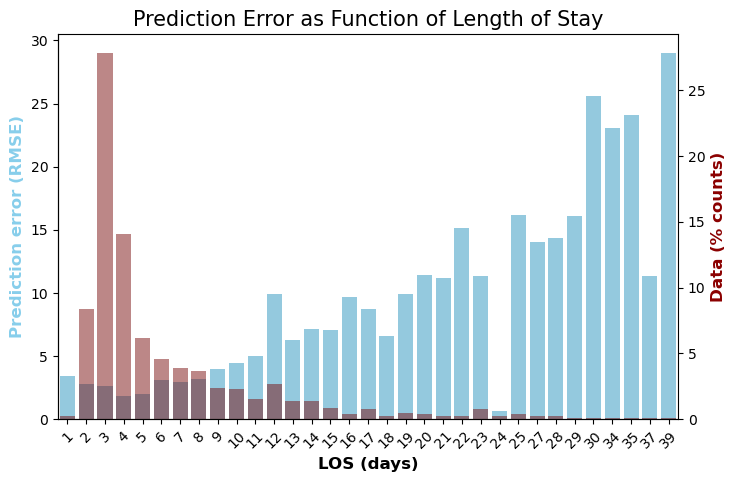

In [790]:
"""Plot LOS from data with the average prediction error overlaid."""

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,5))
sns.barplot(x = NB2_preds_actual['length_of_stay'].astype(int),
           y = NB2_preds_actual['RMSE'],
           color = 'skyblue')
axs.set_xlabel('LOS (days)',fontdict = {'fontsize': 12}, fontweight = 'bold')
axs.set_ylabel('Prediction error (RMSE)',fontdict = {'fontsize': 12}, fontweight = 'bold', color = 'skyblue')
#axs.axhline(y = 6.1, linestyle = '--', color = 'grey', linewidth = 1)
sns.despine()
axs.set_title('Prediction Error as Function of Length of Stay',
          fontdict = {'fontsize':15})
#axs.text(x = 34, y = 5.5, s = 'Error using median LOS', color = 'grey', fontdict = {'fontsize': 12})
plt.xticks(rotation = 45)

#Create overlapping set of axes with shared x axis
ax2 = axs.twinx()

#plot counts of data LOS
sns.barplot(x = NB2_preds_actual['length_of_stay'].astype(int),
            y = NB2_preds_actual['length_of_stay'].astype(int),
            #plot normalized count for each bin (number of days), rather than mean
            estimator = lambda x: len(x) / len(merged_colorectal) * 100,
            ax = ax2,
            alpha = 0.5,
            color = 'darkred')
ax2.set_ylabel('Data (% counts)', fontweight = 'bold',fontdict = {'fontsize': 12}, color = 'darkred')

plt.show();

In [791]:
"""Calculate the mean test and training RMSEs for both models"""

#Negative binomial regression model 
NB2_mean_test_RMSE = (np.sum(NB2_test_RMSEs) / len(NB2_test_RMSEs))
NB2_mean_train_RMSE = (np.sum(NB2_train_RMSEs)/len(NB2_train_RMSEs))

print(f" The average RMSE for NB2 model predictions on training folds  = {NB2_mean_train_RMSE}")
print(f" The average RMSE for NB2 model predictions on test folds = {NB2_mean_test_RMSE}")

 The average RMSE for NB2 model predictions on training folds  = 4.486375103954951
 The average RMSE for NB2 model predictions on test folds = 4.71214089378143


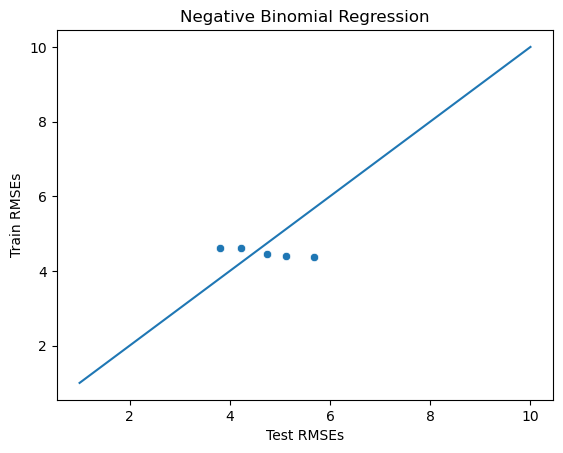

In [792]:
"""Let's plot the train and test RMSEs against one another. This plot will tell us about the variance among both
sets of RMSEs, and allow us to diagnose systematic under- or overfitting."""

fig, axes = plt.subplots()
sns.scatterplot(x = NB2_test_RMSEs, y = NB2_train_RMSEs)
x = np.linspace(1,10,num = 300)
axes.plot(x,x)
axes.set_xlabel("Test RMSEs")
axes.set_ylabel("Train RMSEs")
axes.set_title('Negative Binomial Regression')

plt.show()

/var/folders/v9/483tmlvj28ldt2s2wvphywvxd4j0g_/T/ipykernel_77189/276112841.py:72: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



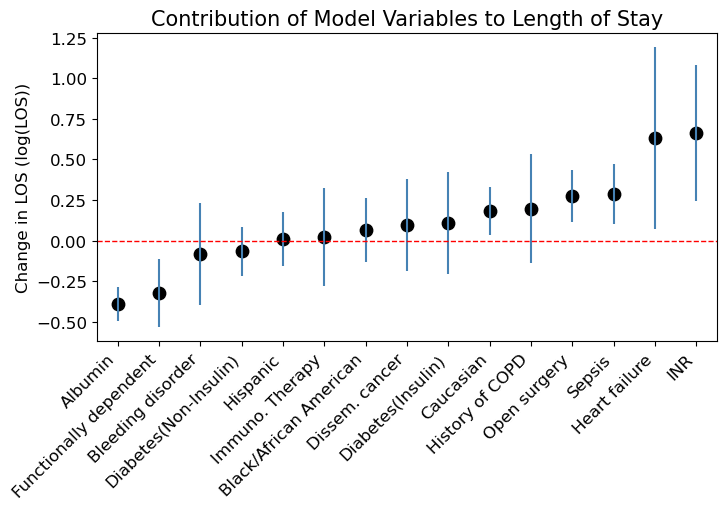

In [793]:
coefplot(results = NB2_reg_pred_revised, coef_labels = new_vars, 
         vars_to_drop = ['American Indian or Alaskan Native',
                        'C(race, Treatment(1))[T.Unknown/Not Reported]']
        )

In [813]:
"""Function to remove outliers for plotting, etc"""
def find_outliers(df, col, num_std_dev):
    threshold = np.mean(df[col]) + num_std_dev * df[col].std()
    
    return df[df[col] < threshold]    

In [815]:
albumin_no_outliers = find_outliers(merged_colorectal, 'albumin',3)

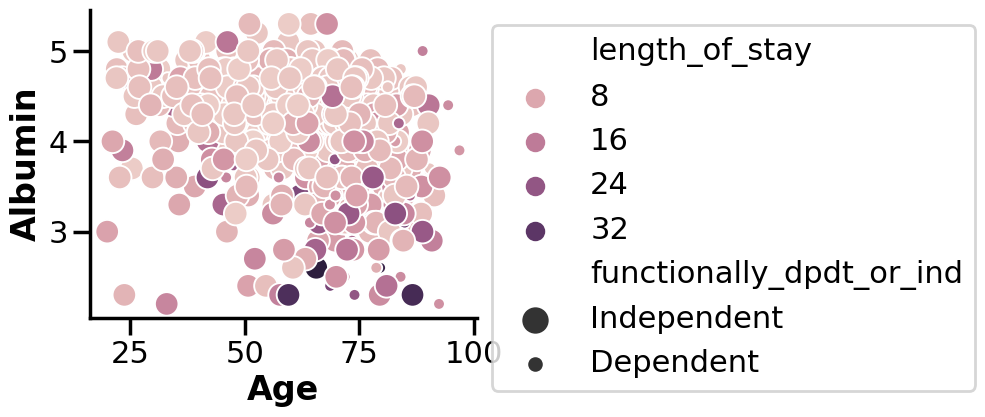

In [818]:
"""Explore relationship between albumin, age and functional health status. Given the role of Albumin
in this """

fig, axs = plt.subplots(figsize = (5,4))
sns.scatterplot(y = albumin_no_outliers['albumin'],
               x = albumin_no_outliers['age'],
               hue = albumin_no_outliers['length_of_stay'],
               size = albumin_no_outliers['functionally_dpdt_or_ind'],
               ax = axs)
axs.set_xlabel('Age', fontweight = 'bold')
axs.set_ylabel('Albumin', fontweight = 'bold')
axs.legend(bbox_to_anchor = (1,1))
#axs.set_title('Albumin and LOS/Health', fontweight = 'bold')
sns.despine()

In [1465]:
"""Let's assess the extent of missing data in the columns of interest."""

cols_for_pred = ['age',
              'race',
              'open_or_laparoscopic',
              'bmi',
              'case_acuity',
              'functionally_dpdt_or_ind']
cols_for_pred.extend(lab_tests)
cols_for_pred.extend(comorb_cols)
cols_for_pred

['age',
 'race',
 'open_or_laparoscopic',
 'bmi',
 'case_acuity',
 'functionally_dpdt_or_ind',
 'serum_sodium',
 'bun',
 'serum_creatinine',
 'albumin',
 'total_bilirubin',
 'ast_sgot',
 'alkaline_phosphatase',
 'wbc',
 'hematocrit',
 'hemoglobin_a1c_(hba1c)',
 'platelet_count',
 'inr',
 'ptt',
 'ventilator_dependent',
 'history_of_severe_copd',
 'ascites',
 'heart_failure',
 'sepsis_(sirs_sepsis_septic_shock)_(48h)',
 'hypertension_requiring_medication',
 'disseminated_cancer',
 'immunosuppressive_therapy',
 'malnourishment',
 'bleeding_disorder',
 'preop_rbc_transfusions',
 'diabetes_mellitus',
 'current_smoker_within_1_year',
 'dyspnea',
 'has_sepsis']

In [1471]:
cols_for_pred = [i for i in cols_for_pred if i not in ['hemoglobin_a1c_(hba1c)','sepsis_(sirs_sepsis_septic_shock)_(48h)','malnourishment','ascites']]

In [1472]:
cols_for_pred

['age',
 'race',
 'open_or_laparoscopic',
 'bmi',
 'case_acuity',
 'functionally_dpdt_or_ind',
 'serum_sodium',
 'bun',
 'serum_creatinine',
 'albumin',
 'total_bilirubin',
 'ast_sgot',
 'alkaline_phosphatase',
 'wbc',
 'hematocrit',
 'platelet_count',
 'inr',
 'ptt',
 'ventilator_dependent',
 'history_of_severe_copd',
 'heart_failure',
 'hypertension_requiring_medication',
 'disseminated_cancer',
 'immunosuppressive_therapy',
 'bleeding_disorder',
 'preop_rbc_transfusions',
 'diabetes_mellitus',
 'current_smoker_within_1_year',
 'dyspnea',
 'has_sepsis']

In [1489]:
los_prediction = merged_colorectal[cols_for_pred]

In [1490]:
los_prediction = pd.concat([los_prediction,merged_colorectal['length_of_stay']], axis = 1)

In [1492]:
los_prediction.columns

Index(['age', 'race', 'open_or_laparoscopic', 'bmi', 'case_acuity',
       'functionally_dpdt_or_ind', 'serum_sodium', 'bun', 'serum_creatinine',
       'albumin', 'total_bilirubin', 'ast_sgot', 'alkaline_phosphatase', 'wbc',
       'hematocrit', 'platelet_count', 'inr', 'ptt', 'ventilator_dependent',
       'history_of_severe_copd', 'heart_failure',
       'hypertension_requiring_medication', 'disseminated_cancer',
       'immunosuppressive_therapy', 'bleeding_disorder',
       'preop_rbc_transfusions', 'diabetes_mellitus',
       'current_smoker_within_1_year', 'dyspnea', 'has_sepsis',
       'length_of_stay'],
      dtype='object')

In [1495]:
los_prediction.columns = los_prediction.columns.str.replace("_"," ")

In [1496]:
los_prediction.to_csv('los_prediction.csv', index = False)